In [144]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

In [290]:
# geospatial and graphing
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text
from pyfonts import load_font

## Nashville <b>Crime</b> and Community Amenities Analysis

This project will be an examination of how crime and accessibility of community resources vary
across communities in Nashville and if there are any patterns or correlations to be found
between them. I believe that it could shed light on how underprivileged communities with less
access to amenities such as housing, green areas, and other resources influence crime rates.
The data to be used in this analysis will include local data to Nashville and Davidson county,
much of which is obtained through the Nashville Open Data Portal online.

<h5><b>Data Question</b></h5>
How does crime in Nashville vary across neighborhoods with different community resources,
and what correlations or patterns are there?

### Cleaning

In [3]:
# Read GeoJson
incidents = gpd.read_file('../data/Metro_Nashville_Police_Department_Incidents.geojson')

In [4]:
# Shape
incidents.shape

(894114, 35)

In [5]:
incidents.head(3)

,OBJECTID,Primary_Key,Incident_Number,Report_Type,Report_Type_Description,Incident_Status_Code,Incident_Status_Description,Investigation_Status,Incident_Location,Latitude,Longitude,RPA,Zone,Location_Code,Location_Description,Offense_Number,Offense_NIBRS,Offense_Description,Weapon_Description,Victim_Number,Domestic_Related,Victim_Type,Victim_Description,Victim_Gender,Victim_Race,Victim_Ethnicity,Victim_County_Resident,Mapped_Location,POINT_X,POINT_Y,ZIP_Code,Weapon_Primary,Incident_Occurred,Incident_Reported,geometry
0,1,20180005702_23,20180005702,D,DISPATCHED,O,OPEN,Open,BELL RD,36.170,-86.600,9527.0,521.0,90.0,APARTMENT,2.0,520,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,S,SOCIETY,None,None,None,None,None,None,None,None,01,2018-01-03 02:50:00+00:00,2018-01-03 04:15:00+00:00,POINT (-86.60000 36.17000)
1,2,20180005926_11,20180005926,S,SUSPECT,A,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,NaN,NaN,13.0,"HIGHWAY, ROAD, ALLEY",1.0,35A,MARIJUANA - POSSESS,NONE,1,No,S,SOCIETY,None,None,None,None,None,None,None,37115.0,17,2018-01-03 04:20:00+00:00,2018-01-03 04:42:00+00:00,POINT (-86.75600 36.26900)
2,3,20180005926_21,20180005926,S,SUSPECT,A,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,NaN,NaN,13.0,"HIGHWAY, ROAD, ALLEY",2.0,35B,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,S,SOCIETY,None,None,None,None,None,None,None,37115.0,17,2018-01-03 04:20:00+00:00,2018-01-03 04:42:00+00:00,POINT (-86.75600 36.26900)


#### Dropping Empty or Unnecessary Columns

In [6]:
# Set up new DF to trim
incidents_trim = incidents

In [7]:
incidents_trim.columns

Index(['OBJECTID', 'Primary_Key', 'Incident_Number', 'Report_Type',
       'Report_Type_Description', 'Incident_Status_Code',
       'Incident_Status_Description', 'Investigation_Status',
       'Incident_Location', 'Latitude', 'Longitude', 'RPA', 'Zone',
       'Location_Code', 'Location_Description', 'Offense_Number',
       'Offense_NIBRS', 'Offense_Description', 'Weapon_Description',
       'Victim_Number', 'Domestic_Related', 'Victim_Type',
       'Victim_Description', 'Victim_Gender', 'Victim_Race',
       'Victim_Ethnicity', 'Victim_County_Resident', 'Mapped_Location',
       'POINT_X', 'POINT_Y', 'ZIP_Code', 'Weapon_Primary', 'Incident_Occurred',
       'Incident_Reported', 'geometry'],
      dtype='object')

In [8]:
# These all look like empty columns
incidents_trim['POINT_X'].unique()

array([None], dtype=object)

In [9]:
incidents_trim['POINT_Y'].unique()

array([None], dtype=object)

In [10]:
incidents_trim['Mapped_Location'].unique()

array([None], dtype=object)

In [11]:
# Object ID just looks like a 1 based index duplicate
incidents_trim[incidents_trim['OBJECTID'] == incidents_trim['OBJECTID'].max()]

# FROM THE FUTURE LOU: THIS IS MY UNIQUE IDENTIFIER FOR EACH RECORD! BECAUSE IT IS JUST A 1 BASED INDEX!

,OBJECTID,Primary_Key,Incident_Number,Report_Type,Report_Type_Description,Incident_Status_Code,Incident_Status_Description,Investigation_Status,Incident_Location,Latitude,Longitude,RPA,Zone,Location_Code,Location_Description,Offense_Number,Offense_NIBRS,Offense_Description,Weapon_Description,Victim_Number,Domestic_Related,Victim_Type,Victim_Description,Victim_Gender,Victim_Race,Victim_Ethnicity,Victim_County_Resident,Mapped_Location,POINT_X,POINT_Y,ZIP_Code,Weapon_Primary,Incident_Occurred,Incident_Reported,geometry
894113,894114,20240487277_11,20240487277,D,DISPATCHED,U,UNFOUNDED,Closed,3324 3324,36.084,-86.585,NaN,NaN,53.0,School-Elementary/Secondary,1.0,810,LOST PROPERTY,NONE,1,No,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,None,None,None,37013.0,17,2024-05-24 14:00:00+00:00,2024-07-24 06:51:00+00:00,POINT (-86.58500 36.08400)


In [12]:
# YES
incidents_trim['OBJECTID'].nunique()

894114

In [13]:
# Let's look at the middle columns that keep getting cut out
incidents_trim[['Primary_Key', 'Incident_Number', 'Location_Code', 'Location_Description', 'Offense_Number',
       'Offense_NIBRS', 'Offense_Description', 'Weapon_Description', 'Victim_Number', 'Domestic_Related', 'Victim_Type']].head()

,Primary_Key,Incident_Number,Location_Code,Location_Description,Offense_Number,Offense_NIBRS,Offense_Description,Weapon_Description,Victim_Number,Domestic_Related,Victim_Type
0,20180005702_23,20180005702,90.0,APARTMENT,2.0,520,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,S
1,20180005926_11,20180005926,13.0,"HIGHWAY, ROAD, ALLEY",1.0,35A,MARIJUANA - POSSESS,NONE,1,No,S
2,20180005926_21,20180005926,13.0,"HIGHWAY, ROAD, ALLEY",2.0,35B,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,S
3,20180004613_11,20180004613,22.0,"RESIDENCE, HOME",1.0,220,BURGLARY- AGGRAVATED,PERSONAL (HANDS),1,No,I
4,20180004654_22,20180004654,22.0,"RESIDENCE, HOME",2.0,220,BURGLARY- AGGRAVATED,NONE,2,No,I


In [14]:
# Checking Victim Num
incidents_trim[['Incident_Number', 'Location_Description', 'Offense_Description', 'Weapon_Description', 'Victim_Number']][incidents_trim['Incident_Number'] == 20180005702]

,Incident_Number,Location_Description,Offense_Description,Weapon_Description,Victim_Number
0,20180005702,APARTMENT,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3
798,20180005702,APARTMENT,"ROBBERY, AGGRAVATED, HANDGUN",HANDGUN,1
799,20180005702,APARTMENT,"ROBBERY, AGGRAVATED, HANDGUN",HANDGUN,2


<h5><b>UNNECESSARY COLUMNS</b></h5>
RPA: MNPD reporting zone for the incident<br>
Zone: MNPD zone / patrol area where the incident occurred<br>
Object ID just is just a 1 based index duplicate<br>

<h5><b>EMPTY COLUMNS</b></h5>
Mapped_Location<br>
POINT_X<br>
POINT_Y<br>

In [15]:
# Dropping unnecessary columns
incidents_trim = incidents_trim.drop(columns=['RPA', 'Zone', 'Mapped_Location', 'POINT_X', 'POINT_Y'])

#### Renaming Columns

In [16]:
incidents_trim.columns

Index(['OBJECTID', 'Primary_Key', 'Incident_Number', 'Report_Type',
       'Report_Type_Description', 'Incident_Status_Code',
       'Incident_Status_Description', 'Investigation_Status',
       'Incident_Location', 'Latitude', 'Longitude', 'Location_Code',
       'Location_Description', 'Offense_Number', 'Offense_NIBRS',
       'Offense_Description', 'Weapon_Description', 'Victim_Number',
       'Domestic_Related', 'Victim_Type', 'Victim_Description',
       'Victim_Gender', 'Victim_Race', 'Victim_Ethnicity',
       'Victim_County_Resident', 'ZIP_Code', 'Weapon_Primary',
       'Incident_Occurred', 'Incident_Reported', 'geometry'],
      dtype='object')

In [17]:
incidents_trim = incidents_trim.rename(columns={'OBJECTID' : 'objid',
                               'Primary_Key' : 'primary_key',
                               'Incident_Number' : 'inc_num',
                               'Report_Type' : 'report_code',
                               'Report_Type_Description' : 'report_desc',
                               'Incident_Status_Code' : 'inc_status_code',
                               'Incident_Status_Description' : 'inc_status_desc',
                               'Investigation_Status' : 'investigation_status', 
                               'Incident_Location' : 'inc_loc',
                               'Latitude' : 'lat',
                               'Longitude' : 'long',
                               'Location_Code' : 'loc_code',
                               'Location_Description' : 'loc_desc',
                               'Offense_Number' : 'offense_num',
                               'Offense_NIBRS' : 'offense_nibrs',
                               'Offense_Description' : 'offense_desc',
                               'Weapon_Description' : 'weapon',
                               'Victim_Number' : 'v_num', 
                               'Domestic_Related' : 'domestic_flag',
                               'Victim_Type' : 'v_type',
                               'Victim_Description' : 'v_desc',
                               'Victim_Gender' : 'v_gender',
                               'Victim_Race' : 'v_race',
                               'Victim_Ethnicity' : 'v_ethnicity',
                               'Victim_County_Resident' : 'v_county_resident',
                               'ZIP_Code' : 'zip',
                               'Weapon_Primary' : 'weapon_code',
                               'Incident_Occurred' : 'inc_time',
                               'Incident_Reported' : 'report_time'
                              })
                               

#### Saving flags separately from main dataframe

In [18]:
len(incidents_trim.columns)/2

15.0

In [19]:
# First Half
incidents_trim[['primary_key', 'inc_num', 'report_code', 'report_desc',
                'inc_status_code', 'inc_status_desc', 'investigation_status',
                'inc_loc', 'lat', 'long', 'loc_code', 'loc_desc',
                'offense_num', 'offense_nibrs', 'offense_desc'
               ]].head(2)

,primary_key,inc_num,report_code,report_desc,inc_status_code,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_nibrs,offense_desc
0,20180005702_23,20180005702,D,DISPATCHED,O,OPEN,Open,BELL RD,36.170,-86.600,90.0,APARTMENT,2.0,520,"WEAPON OFFENSE, CRIMINAL ATTEMPT"
1,20180005926_11,20180005926,S,SUSPECT,A,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13.0,"HIGHWAY, ROAD, ALLEY",1.0,35A,MARIJUANA - POSSESS


In [20]:
incidents_trim['report_desc'].unique()

array(['DISPATCHED', 'SUSPECT', 'WITNESS', None], dtype=object)

In [21]:
incidents_trim['inc_status_desc'].unique()

array(['OPEN', 'CLEARED BY ARREST', 'UNFOUNDED', 'REFUSED TO COOPERATE',
       'PROSECUTION DECLINED', 'DEATH OF OFFENDER',
       'JUVENILE, NO CUSTODY', None, 'EXTRADITION DECLINED'], dtype=object)

In [22]:
# I'm leaving location code in because of the somewhat vast variety of entries
# Plan is to condense some of the location categories into more general places in the future, codes might be useful for that
incidents_trim['loc_desc'].nunique()

62

In [23]:
# Second Half
incidents_trim[['weapon', 'v_num', 'domestic_flag', 'v_type', 'v_desc',
                'v_gender', 'v_race', 'v_ethnicity', 'v_county_resident', 'zip',
                'weapon_code', 'inc_time', 'report_time', 'geometry'
               ]].head(2)

,weapon,v_num,domestic_flag,v_type,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,weapon_code,inc_time,report_time,geometry
0,HANDGUN,3,No,S,SOCIETY,None,None,None,None,None,01,2018-01-03 02:50:00+00:00,2018-01-03 04:15:00+00:00,POINT (-86.60000 36.17000)
1,NONE,1,No,S,SOCIETY,None,None,None,None,37115.0,17,2018-01-03 04:20:00+00:00,2018-01-03 04:42:00+00:00,POINT (-86.75600 36.26900)


In [24]:
incidents_trim['weapon'].unique()

array(['HANDGUN', 'NONE', 'PERSONAL (HANDS)', 'CLUB', 'Unarmed', 'DRUGS',
       'LETHAL/CUTTING INSTRUMENT', 'OTHER', 'REVOLVER', 'SHOTGUN',
       'MOTOR VEHICLE', 'HANDGUN - SEMIAUTOMATIC', None,
       'FIRE/INCENDIARY DEVICES', 'RIFLE', 'OTHER FIREARM', 'POISON',
       'EXPLOSIVES', 'ASPHYXIATION'], dtype=object)

In [25]:
incidents_trim['v_desc'].unique()

array(['SOCIETY', 'INDIVIDUAL (18 AND OVER)', 'BUSINESS', 'UNKNOWN',
       'POLICE OFFICER', 'RELIGIOUS', 'GOVERNMENT',
       'FINANCIAL INSTITUTION', 'OTHER', None,
       'CITIZEN INFORMATION NOTICE', 'DOMESTIC VIOLENCE NOTICE'],
      dtype=object)

In [26]:
# This is the only race information I have so it will be kept
incidents_trim['v_race'].unique()
# 03 is not a code in the metadata, maybe a mistake?

array([None, 'W', 'B', 'U', 'A', 'P', 'I', 'O', 'H', '03', 'T', 'C'],
      dtype=object)

In [27]:
incidents_trim['v_ethnicity'].unique()

array([None, 'Non-Hispanic', 'Hispanic', 'Unknown'], dtype=object)

In [28]:
# SAVING TO FLAG SPECIFIC DATAFRAME

# This will allow me to work with the text/description data more easily and still be able to include the codes later if
# I need to, using the objid column to rejoin them
incidents_flags = incidents_trim[['objid', 'report_code', 'inc_status_code', 'offense_nibrs', 'v_type', 'weapon_code']]

In [29]:
# DROPPING FROM INCIDENTS_TRIM
incidents_trim = incidents_trim.drop(columns = ['report_code', 'inc_status_code', 'offense_nibrs', 'v_type', 'weapon_code'])

#### Column Type Cleaning

In [30]:
incidents_trim.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.17,-86.6,90.0,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00+00:00,2018-01-03 04:15:00+00:00,POINT (-86.60000 36.17000)


In [31]:
incidents_trim.dtypes

objid                                 int64
primary_key                          object
inc_num                               int64
report_desc                          object
inc_status_desc                      object
investigation_status                 object
inc_loc                              object
lat                                 float64
long                                float64
loc_code                            float64
loc_desc                             object
offense_num                         float64
offense_desc                         object
weapon                               object
v_num                                 int64
domestic_flag                        object
v_desc                               object
v_gender                             object
v_race                               object
v_ethnicity                          object
v_county_resident                    object
zip                                  object
inc_time                datetime

In [32]:
# Casting objid as string
incidents_trim['objid'] = incidents_trim['objid'].astype(str)

In [33]:
# Casting inc_num as text
incidents_trim['inc_num'] = incidents_trim['inc_num'].astype(str)

In [34]:
# Casting loc_code as text
incidents_trim['loc_code'] = incidents_trim['loc_code'].astype(str).str.replace('.0', '')

In [35]:
# Trimming '.0' from zip col
incidents_trim['zip'] = incidents_trim['zip'].str.replace('.0', '')

In [36]:
# Fixing '+00:00' from datetime columns
incidents_trim['inc_time'] = incidents_trim['inc_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
incidents_trim['report_time'] = incidents_trim['report_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [37]:
# It's a string now i guess
incidents_trim[['inc_time', 'report_time']].dtypes

inc_time       object
report_time    object
dtype: object

In [38]:
incidents_trim['inc_time'] = pd.to_datetime(incidents_trim['inc_time'], format='%Y-%m-%d %H:%M:%S')
incidents_trim['report_time'] = pd.to_datetime(incidents_trim['report_time'], format='%Y-%m-%d %H:%M:%S')

In [39]:
# Yay fixed
incidents_trim[['inc_time', 'report_time']].dtypes

inc_time       datetime64[ns]
report_time    datetime64[ns]
dtype: object

#### Adding Year Col

In [40]:
incidents_trim.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.17,-86.6,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000)


In [41]:
# Adding specific year column for incident time
incidents_trim['inc_yr'] = incidents_trim['inc_time'].dt.year

In [42]:
# Perf
incidents_trim.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.17,-86.6,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018


#### Grouping offenses by type

In [43]:
incidents_trim.head(2)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.170,-86.600,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018


In [44]:
# Not viable too vast
incidents_trim['offense_desc'].nunique()

594

In [45]:
# I believe it's time to whip out my secret weapon...
# NIBRS!!!!!
incidents_flags.head(1)

,objid,report_code,inc_status_code,offense_nibrs,v_type,weapon_code
0,1,D,O,520,S,01


In [46]:
# Much better... still a little rough but I got it
incidents_flags['offense_nibrs'].nunique()

74

In [47]:
# Checking for duplication
incidents_trim['objid'].nunique()

894114

In [48]:
# All good
incidents.shape[0]

894114

In [49]:
incidents_flags.dtypes

objid               int64
report_code        object
inc_status_code    object
offense_nibrs      object
v_type             object
weapon_code        object
dtype: object

In [50]:
incidents_trim.dtypes

objid                           object
primary_key                     object
inc_num                         object
report_desc                     object
inc_status_desc                 object
investigation_status            object
inc_loc                         object
lat                            float64
long                           float64
loc_code                        object
loc_desc                        object
offense_num                    float64
offense_desc                    object
weapon                          object
v_num                            int64
domestic_flag                   object
v_desc                          object
v_gender                        object
v_race                          object
v_ethnicity                     object
v_county_resident               object
zip                             object
inc_time                datetime64[ns]
report_time             datetime64[ns]
geometry                      geometry
inc_yr                   

In [52]:
# Fixing the typing for the merge
incidents_flags['objid'] = incidents_flags['objid'].astype(str)

In [53]:
incidents_flags.shape[0]

894114

In [54]:
incidents_trim.shape[0]

894114

In [55]:
# SHOUTOUT TO MY OBJECT ID COLUMN I OWE YOU EVERYTHING NO DUPLICATION!
incidents.shape[0]

894114

In [57]:
# Rejoining the NIBRS column ONLY
incidents_nibrs = pd.merge(
    left=incidents_trim, 
    right=incidents_flags[['objid', 'offense_nibrs']],
    how='left',
    left_on='objid',
    right_on='objid'
)

In [58]:
# Moment of truth (dupe check)
incidents_nibrs['objid'].nunique()

894114

In [59]:
# saving back to incidents_trim for the rest of the notebook
incidents_trim = incidents_nibrs

##### <h3>I'm referencing the metadata EXTENSIVELY for my next trick</h3>
I'm going to categorize rows with the categories outlined in the next cell.<br>
<br>
This will allow me to identify crime way easier with these broader categories. Much of the data is extremely specific and this will broaden my analysis.

<p><b>THEFT</b>: '23_', 220 (Burglary), 240 (Motor Vehicle Theft), 120 (robbery)<br>
<br>
<b>MURDER</b>: 09A<br>
<br>
<b>SEXUAL CRIMES</b>: '11_' (forcible), 64A Sexual Human Trafficking, '40_' (Prostitution)<br>
<br>
<b>DRUG CRIMES</b>: '35_'<br>
<br>
<b>PROPERTY CRIMES</b>: 200 Arson, 290 Property Offenses<br>
<br>
<b>DRUNKENNESS/DUI</b>: 90D, 90E<br>
<br>
<b>SUICIDES</b>: 690</p>

In [60]:
# Define row based function to apply to dataframe
def sort_crimes(offense_nibrs):
    # MURDER
    if '09A' in offense_nibrs:
        return 'MURDER'
    # SUICIDE
    elif '690' in offense_nibrs:
        return 'SUICIDE'
    # SEXUAL CRIMES
    elif offense_nibrs.startswith('11') or offense_nibrs.startswith('40') or '64A' in offense_nibrs:
        return 'SEXUAL'
    # THEFT
    elif offense_nibrs.startswith('23') or offense_nibrs in ['220', '240', '120']:
        return 'THEFT'
    # DRUG
    elif offense_nibrs.startswith('35'):
        return 'DRUG'
    # PROPERTY
    elif offense_nibrs in ['200', '290']:
        return 'PROPERTY'
    # DUI/DRUNKENNESS
    elif offense_nibrs in ['90D', '90E']:
        return 'INTOXICATION'
    else:
        return 'OTHER'

In [61]:
# Initializing empty column
incidents_trim['crime_cat'] = ''

In [62]:
incidents_trim[['offense_nibrs', 'crime_cat']][0:20].head(2)

,offense_nibrs,crime_cat
0,520,
1,35A,


In [63]:
# testing
incidents_trim['offense_nibrs'][47:67].apply(sort_crimes)

47        DRUG
48        DRUG
49    PROPERTY
50    PROPERTY
51    PROPERTY
52        DRUG
53        DRUG
54        DRUG
55        DRUG
56        DRUG
57       OTHER
58       THEFT
59       OTHER
60    PROPERTY
61       OTHER
62    PROPERTY
63       THEFT
64       THEFT
65       OTHER
66       THEFT
Name: offense_nibrs, dtype: object

In [64]:
# Me from the future: there are missing values how amazing
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True)]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
4059,4060,20180024946_11,20180024946,SUSPECT,OPEN,Open,ANDERSON RD,36.080,-86.610,22,"RESIDENCE, HOME",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2018-01-09 02:15:00,2018-01-09 02:58:00,POINT (-86.61000 36.08000),2018,None,
22235,22236,20180840074_11,20180840074,SUSPECT,OPEN,Open,MYATT DR,36.290,-86.700,14,"HOTEL, MOTEL, ETC.",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2018-10-03 21:55:00,2018-10-03 22:40:00,POINT (-86.70000 36.29000),2018,None,
34031,34032,20180633549_11,20180633549,SUSPECT,OPEN,Open,MOSS TRL,36.310,-86.710,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,DRUGS,1,No,SOCIETY,None,None,None,None,None,2018-07-23 22:40:00,2018-07-24 21:01:00,POINT (-86.71000 36.31000),2018,None,
34389,34390,20200011945_11,20200011945,SUSPECT,OPEN,Open,OLD HICKORY BLVD,36.250,-86.640,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2020-01-06 22:10:00,2020-01-07 02:12:00,POINT (-86.64000 36.25000),2020,None,
36874,36875,20190428132_33,20190428132,DISPATCHED,CLEARED BY ARREST,Closed,710 710,36.073,-86.621,22,"RESIDENCE, HOME",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37013,2019-06-05 13:50:00,2019-06-05 15:01:00,POINT (-86.62100 36.07300),2019,None,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870451,870452,20240137956_11,20240137956,SUSPECT,CLEARED BY ARREST,Closed,E OLD HICKORY BLVD & FARRIS AVE,36.263,-86.688,13,"HIGHWAY, ROAD, ALLEY",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN - SEMIAUTOMATIC,1,No,SOCIETY,None,None,None,None,37115,2024-02-28 03:24:00,2024-02-28 04:00:00,POINT (-86.68800 36.26300),2024,None,
877773,877774,20240715583_11,20240715583,SUSPECT,CLEARED BY ARREST,Closed,100 100,36.162,-86.774,19,PARK,1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,37201,2024-11-04 21:59:00,2024-11-05 00:27:00,POINT (-86.77400 36.16200),2024,None,
881403,881404,20240462815_11,20240462815,SUSPECT,CLEARED BY ARREST,Closed,SPRING ST & N 1ST ST,36.177,-86.775,13,"HIGHWAY, ROAD, ALLEY",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN - SEMIAUTOMATIC,1,No,SOCIETY,None,None,None,None,37207,2024-07-13 07:47:00,2024-09-09 22:18:00,POINT (-86.77500 36.17700),2024,None,
881753,881754,20240693948_11,20240693948,SUSPECT,OPEN,Open,TENNESSEE AVE,36.160,-86.850,20,"PARKING LOT, GARAGE",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2024-10-25 02:20:00,2024-10-25 02:20:00,POINT (-86.85000 36.16000),2024,None,


##### Filling Meth Related rows

In [65]:
# Lets focus on the several meth related incidents first
# Isolating some of the empty rows that describe sale of meth, identifying as 35A for 'Drug/Narcotic Violations'
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True) & (incidents_trim['offense_desc'].str.lower().str.contains('meth'))]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
4059,4060,20180024946_11,20180024946,SUSPECT,OPEN,Open,ANDERSON RD,36.080,-86.610,22,"RESIDENCE, HOME",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2018-01-09 02:15:00,2018-01-09 02:58:00,POINT (-86.61000 36.08000),2018,None,
22235,22236,20180840074_11,20180840074,SUSPECT,OPEN,Open,MYATT DR,36.290,-86.700,14,"HOTEL, MOTEL, ETC.",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2018-10-03 21:55:00,2018-10-03 22:40:00,POINT (-86.70000 36.29000),2018,None,
34031,34032,20180633549_11,20180633549,SUSPECT,OPEN,Open,MOSS TRL,36.310,-86.710,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,DRUGS,1,No,SOCIETY,None,None,None,None,None,2018-07-23 22:40:00,2018-07-24 21:01:00,POINT (-86.71000 36.31000),2018,None,
34389,34390,20200011945_11,20200011945,SUSPECT,OPEN,Open,OLD HICKORY BLVD,36.250,-86.640,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2020-01-06 22:10:00,2020-01-07 02:12:00,POINT (-86.64000 36.25000),2020,None,
45307,45308,20200173917_11,20200173917,SUSPECT,OPEN,Open,4TH AVE S,36.160,-86.780,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2020-03-10 15:04:00,2020-03-10 16:18:00,POINT (-86.78000 36.16000),2020,None,
63579,63580,20180663785_11,20180663785,SUSPECT,OPEN,Open,MOSS TRL,36.310,-86.710,20,"PARKING LOT, GARAGE",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2018-08-02 22:02:00,2018-08-06 19:48:00,POINT (-86.71000 36.31000),2018,None,
77140,77141,20200137909_11,20200137909,SUSPECT,OPEN,Open,ALTA LOMA RD,36.290,-86.700,20,"PARKING LOT, GARAGE",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2020-02-26 22:05:00,2020-02-26 22:35:00,POINT (-86.70000 36.29000),2020,None,
86450,86451,20200071861_11,20200071861,SUSPECT,OPEN,Open,OLD HICKORY BLVD,36.250,-86.640,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2020-01-30 19:35:00,2020-01-30 21:27:00,POINT (-86.64000 36.25000),2020,None,
89306,89307,20200052061_11,20200052061,SUSPECT,OPEN,Open,OLD HICKORY BLVD,36.250,-86.640,13,"HIGHWAY, ROAD, ALLEY",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,None,2020-01-22 19:55:00,2020-01-22 22:46:00,POINT (-86.64000 36.25000),2020,None,
104872,104873,20190569920_11,20190569920,DISPATCHED,CLEARED BY ARREST,Closed,4640 4640,36.215,-86.596,20,"PARKING LOT, GARAGE",1.0,Sale -Cont.Sub.-Meth.5 gr or more,NONE,1,No,SOCIETY,None,None,None,None,37076,2019-07-31 22:00:00,2019-07-31 23:28:00,POINT (-86.59600 36.21500),2019,None,


In [66]:
# Checking to see if the 'None' values are actually just the string 'None'
incidents_trim.loc[incidents_trim['offense_nibrs'].str.lower() == 'none']

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat


In [67]:
# Help from DK: Mask statement to fill null values with drug NIBRS flag '35A'
mask = (
    (incidents_trim['offense_nibrs'].isna()) &
    (incidents_trim['offense_desc'].str.lower().str.contains('meth'))
)
incidents_trim.loc[mask, 'offense_nibrs'] = incidents_trim.loc[mask, 'offense_nibrs'].fillna('35A')

In [68]:
# Checking... Good!
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True) & (incidents_trim['offense_desc'].str.lower().str.contains('meth'))]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat


##### Filling OOP Firearms Violation with 'other'

In [69]:
# Checking what's left
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True)]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
36874,36875,20190428132_33,20190428132,DISPATCHED,CLEARED BY ARREST,Closed,710 710,36.073,-86.621,22,"RESIDENCE, HOME",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37013,2019-06-05 13:50:00,2019-06-05 15:01:00,POINT (-86.62100 36.07300),2019,None,
184767,184768,20210484601_11,20210484601,DISPATCHED,CLEARED BY ARREST,Closed,4000 4000,36.220,-86.727,20,"PARKING LOT, GARAGE",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37216,2021-09-15 00:32:00,2021-09-15 01:08:00,POINT (-86.72700 36.22000),2021,None,
204201,204202,20210341066_23,20210341066,DISPATCHED,CLEARED BY ARREST,Closed,FAIRFIELD AVE & HERMITAGE AVE,36.154,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37210,2021-06-22 23:42:00,2021-06-23 01:04:00,POINT (-86.75600 36.15400),2021,None,
207710,207711,20180110812_11,20180110812,DISPATCHED,OPEN,Open,GREEN TRAILS CT,36.040,-86.700,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2018-02-02 23:30:00,2018-02-03 02:13:00,POINT (-86.70000 36.04000),2018,None,
215337,215338,20180109645_11,20180109645,DISPATCHED,OPEN,Open,JACKSON ST,36.170,-86.800,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,OTHER,1,No,SOCIETY,None,None,None,None,None,2018-02-02 07:00:00,2018-02-02 18:53:00,POINT (-86.80000 36.17000),2018,None,
326573,326574,20180984688_12,20180984688,DISPATCHED,OPEN,Open,NETHERLANDS DR,36.200,-86.600,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,2,No,SOCIETY,None,None,None,None,None,2018-11-16 21:00:00,2018-11-26 02:00:00,POINT (-86.60000 36.20000),2018,None,
341283,341284,20181066987_11,20181066987,SUSPECT,CLEARED BY ARREST,Closed,555 555,36.268,-86.700,90,APARTMENT,1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37115,2018-12-28 07:00:00,2018-12-28 13:00:00,POINT (-86.70000 36.26800),2018,None,
345676,345677,20180510058_32,20180510058,DISPATCHED,CLEARED BY ARREST,Closed,433 433,36.202,-86.693,55,Shopping Mall,3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37214,2018-06-12 16:45:00,2018-06-12 17:53:00,POINT (-86.69300 36.20200),2018,None,
351468,351469,20190198431_22,20190198431,DISPATCHED,OPEN,Open,ASHEFORD TRCE,36.040,-86.620,22,"RESIDENCE, HOME",2.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,2,No,SOCIETY,None,None,None,None,None,2019-03-13 23:30:00,2019-03-14 03:01:00,POINT (-86.62000 36.04000),2019,None,
375602,375603,20230295518_11,20230295518,DISPATCHED,OPEN,Open,WOODWAY,36.180,-86.590,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2023-05-20 13:00:00,2023-05-20 17:38:00,POINT (-86.59000 36.18000),2023,None,


In [70]:
# Checking the size Order of Protection Firearms Violation
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True) & (incidents_trim['offense_desc'] == 'ORDER OF PROTECTION FIREARMS VIOLATION')].shape[0]

21

In [71]:
# Checking what the NIBRS flag is for row with the same offense description
incidents_trim.loc[(incidents_trim['offense_desc'] == 'ORDER OF PROTECTION FIREARMS VIOLATION')]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
36874,36875,20190428132_33,20190428132,DISPATCHED,CLEARED BY ARREST,Closed,710 710,36.073,-86.621,22,"RESIDENCE, HOME",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37013,2019-06-05 13:50:00,2019-06-05 15:01:00,POINT (-86.62100 36.07300),2019,None,
184767,184768,20210484601_11,20210484601,DISPATCHED,CLEARED BY ARREST,Closed,4000 4000,36.220,-86.727,20,"PARKING LOT, GARAGE",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37216,2021-09-15 00:32:00,2021-09-15 01:08:00,POINT (-86.72700 36.22000),2021,None,
204201,204202,20210341066_23,20210341066,DISPATCHED,CLEARED BY ARREST,Closed,FAIRFIELD AVE & HERMITAGE AVE,36.154,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37210,2021-06-22 23:42:00,2021-06-23 01:04:00,POINT (-86.75600 36.15400),2021,None,
341283,341284,20181066987_11,20181066987,SUSPECT,CLEARED BY ARREST,Closed,555 555,36.268,-86.700,90,APARTMENT,1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37115,2018-12-28 07:00:00,2018-12-28 13:00:00,POINT (-86.70000 36.26800),2018,None,
345676,345677,20180510058_32,20180510058,DISPATCHED,CLEARED BY ARREST,Closed,433 433,36.202,-86.693,55,Shopping Mall,3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37214,2018-06-12 16:45:00,2018-06-12 17:53:00,POINT (-86.69300 36.20200),2018,None,
387123,387124,20220076095_11,20220076095,SUSPECT,CLEARED BY ARREST,Closed,155 155,36.154,-86.761,13,"HIGHWAY, ROAD, ALLEY",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN - SEMIAUTOMATIC,1,No,SOCIETY,None,None,None,None,37210,2022-02-18 20:53:00,2022-02-18 20:53:00,POINT (-86.76100 36.15400),2022,None,
390229,390230,20230197611_32,20230197611,DISPATCHED,CLEARED BY ARREST,Closed,278 278,36.086,-86.711,13,"HIGHWAY, ROAD, ALLEY",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,RIFLE,2,No,SOCIETY,None,None,None,None,37211,2023-04-03 16:30:00,2023-04-04 06:43:00,POINT (-86.71100 36.08600),2023,None,
403934,403935,20210529656_32,20210529656,DISPATCHED,REFUSED TO COOPERATE,Closed,S 7TH ST & SYLVAN ST,36.168,-86.757,13,"HIGHWAY, ROAD, ALLEY",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37206,2021-10-11 01:52:00,2021-10-11 02:46:00,POINT (-86.75700 36.16800),2021,None,
499668,499669,20210189041_22,20210189041,DISPATCHED,CLEARED BY ARREST,Closed,1701 1701,36.185,-86.834,22,"RESIDENCE, HOME",2.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37218,2021-04-03 15:35:00,2021-04-04 02:39:00,POINT (-86.83400 36.18500),2021,None,
554816,554817,20210404639_11,20210404639,SUSPECT,CLEARED BY ARREST,Closed,W TRINITY LN & WHITES CREEK PIKE,36.207,-86.792,20,"PARKING LOT, GARAGE",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37207,2021-07-29 20:20:00,2021-07-29 21:36:00,POINT (-86.79200 36.20700),2021,None,


In [72]:
# Are the rows with this specific offense description all empty?
incidents_trim.loc[(incidents_trim['offense_desc'] == 'ORDER OF PROTECTION FIREARMS VIOLATION')].shape[0]

21

In [73]:
# Yes... This will be categorized as OTHER as ultimately it is an order of protection violation and doesn't fall into my predefined categories.
# I will fill the empty values with a string so that my function will run properly and categorize it appropriately.

# Same mask method as last time
mask = (
    (incidents_trim['offense_nibrs'].isna() == True) & 
    (incidents_trim['offense_desc'] == 'ORDER OF PROTECTION FIREARMS VIOLATION')
)
incidents_trim.loc[mask, 'offense_nibrs'] = incidents_trim.loc[mask, 'offense_nibrs'].fillna('other')

In [74]:
# Looking good!
incidents_trim.loc[(incidents_trim['offense_desc'] == 'ORDER OF PROTECTION FIREARMS VIOLATION')]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
36874,36875,20190428132_33,20190428132,DISPATCHED,CLEARED BY ARREST,Closed,710 710,36.073,-86.621,22,"RESIDENCE, HOME",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37013,2019-06-05 13:50:00,2019-06-05 15:01:00,POINT (-86.62100 36.07300),2019,other,
184767,184768,20210484601_11,20210484601,DISPATCHED,CLEARED BY ARREST,Closed,4000 4000,36.220,-86.727,20,"PARKING LOT, GARAGE",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37216,2021-09-15 00:32:00,2021-09-15 01:08:00,POINT (-86.72700 36.22000),2021,other,
204201,204202,20210341066_23,20210341066,DISPATCHED,CLEARED BY ARREST,Closed,FAIRFIELD AVE & HERMITAGE AVE,36.154,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,3,No,SOCIETY,None,None,None,None,37210,2021-06-22 23:42:00,2021-06-23 01:04:00,POINT (-86.75600 36.15400),2021,other,
341283,341284,20181066987_11,20181066987,SUSPECT,CLEARED BY ARREST,Closed,555 555,36.268,-86.700,90,APARTMENT,1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37115,2018-12-28 07:00:00,2018-12-28 13:00:00,POINT (-86.70000 36.26800),2018,other,
345676,345677,20180510058_32,20180510058,DISPATCHED,CLEARED BY ARREST,Closed,433 433,36.202,-86.693,55,Shopping Mall,3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37214,2018-06-12 16:45:00,2018-06-12 17:53:00,POINT (-86.69300 36.20200),2018,other,
387123,387124,20220076095_11,20220076095,SUSPECT,CLEARED BY ARREST,Closed,155 155,36.154,-86.761,13,"HIGHWAY, ROAD, ALLEY",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN - SEMIAUTOMATIC,1,No,SOCIETY,None,None,None,None,37210,2022-02-18 20:53:00,2022-02-18 20:53:00,POINT (-86.76100 36.15400),2022,other,
390229,390230,20230197611_32,20230197611,DISPATCHED,CLEARED BY ARREST,Closed,278 278,36.086,-86.711,13,"HIGHWAY, ROAD, ALLEY",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,RIFLE,2,No,SOCIETY,None,None,None,None,37211,2023-04-03 16:30:00,2023-04-04 06:43:00,POINT (-86.71100 36.08600),2023,other,
403934,403935,20210529656_32,20210529656,DISPATCHED,REFUSED TO COOPERATE,Closed,S 7TH ST & SYLVAN ST,36.168,-86.757,13,"HIGHWAY, ROAD, ALLEY",3.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37206,2021-10-11 01:52:00,2021-10-11 02:46:00,POINT (-86.75700 36.16800),2021,other,
499668,499669,20210189041_22,20210189041,DISPATCHED,CLEARED BY ARREST,Closed,1701 1701,36.185,-86.834,22,"RESIDENCE, HOME",2.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,2,No,SOCIETY,None,None,None,None,37218,2021-04-03 15:35:00,2021-04-04 02:39:00,POINT (-86.83400 36.18500),2021,other,
554816,554817,20210404639_11,20210404639,SUSPECT,CLEARED BY ARREST,Closed,W TRINITY LN & WHITES CREEK PIKE,36.207,-86.792,20,"PARKING LOT, GARAGE",1.0,ORDER OF PROTECTION FIREARMS VIOLATION,HANDGUN,1,No,SOCIETY,None,None,None,None,37207,2021-07-29 20:20:00,2021-07-29 21:36:00,POINT (-86.79200 36.20700),2021,other,


##### Filling Advertising Sexual Abuse of a Minor with '11'
These rows will be categorized as sexual crimes

In [75]:
# Checking what's left
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True)]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
207710,207711,20180110812_11,20180110812,DISPATCHED,OPEN,Open,GREEN TRAILS CT,36.040,-86.700,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2018-02-02 23:30:00,2018-02-03 02:13:00,POINT (-86.70000 36.04000),2018,None,
215337,215338,20180109645_11,20180109645,DISPATCHED,OPEN,Open,JACKSON ST,36.170,-86.800,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,OTHER,1,No,SOCIETY,None,None,None,None,None,2018-02-02 07:00:00,2018-02-02 18:53:00,POINT (-86.80000 36.17000),2018,None,
326573,326574,20180984688_12,20180984688,DISPATCHED,OPEN,Open,NETHERLANDS DR,36.200,-86.600,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,2,No,SOCIETY,None,None,None,None,None,2018-11-16 21:00:00,2018-11-26 02:00:00,POINT (-86.60000 36.20000),2018,None,
351468,351469,20190198431_22,20190198431,DISPATCHED,OPEN,Open,ASHEFORD TRCE,36.040,-86.620,22,"RESIDENCE, HOME",2.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,2,No,SOCIETY,None,None,None,None,None,2019-03-13 23:30:00,2019-03-14 03:01:00,POINT (-86.62000 36.04000),2019,None,
375602,375603,20230295518_11,20230295518,DISPATCHED,OPEN,Open,WOODWAY,36.180,-86.590,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2023-05-20 13:00:00,2023-05-20 17:38:00,POINT (-86.59000 36.18000),2023,None,
482033,482034,20210286083_24,20210286083,DISPATCHED,UNFOUNDED,Closed,3037 3037,36.027,-86.722,28,"OTHER, UNKNOWN",2.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,4,No,SOCIETY,None,None,None,None,37211,2021-05-24 00:38:00,2021-05-24 06:21:00,POINT (-86.72200 36.02700),2021,None,
711861,711862,20230631210_11,20230631210,SUSPECT,UNFOUNDED,Closed,160 160,36.176,-86.615,53,School-Elementary/Secondary,1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,37211,2023-10-23 16:16:00,2023-10-23 16:16:00,POINT (-86.61500 36.17600),2023,None,
714098,714099,20240346872_11,20240346872,DISPATCHED,OPEN,Open,BISHOPSGATE RD,36.080,-86.660,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2024-05-24 12:00:00,2024-05-24 13:50:00,POINT (-86.66000 36.08000),2024,None,


In [76]:
# Checking shape of isolated rows
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True) & (incidents_trim['offense_desc'] == 'ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR')].shape[0]

8

In [77]:
# Checking if there are other rows with an NIBRS identification of the same offense description
incidents_trim.loc[(incidents_trim['offense_desc'] == 'ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR')].shape[0]

8

In [78]:
# Yes. Same procedure only this time these rows will be properly categorized
mask = (
    (incidents_trim['offense_nibrs'].isna() == True) & 
    (incidents_trim['offense_desc'] == 'ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR')
)
incidents_trim.loc[mask, 'offense_nibrs'] = incidents_trim.loc[mask, 'offense_nibrs'].fillna('11')

In [79]:
# Double Check
incidents_trim.loc[(incidents_trim['offense_desc'] == 'ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR')]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
207710,207711,20180110812_11,20180110812,DISPATCHED,OPEN,Open,GREEN TRAILS CT,36.040,-86.700,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2018-02-02 23:30:00,2018-02-03 02:13:00,POINT (-86.70000 36.04000),2018,11,
215337,215338,20180109645_11,20180109645,DISPATCHED,OPEN,Open,JACKSON ST,36.170,-86.800,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,OTHER,1,No,SOCIETY,None,None,None,None,None,2018-02-02 07:00:00,2018-02-02 18:53:00,POINT (-86.80000 36.17000),2018,11,
326573,326574,20180984688_12,20180984688,DISPATCHED,OPEN,Open,NETHERLANDS DR,36.200,-86.600,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,2,No,SOCIETY,None,None,None,None,None,2018-11-16 21:00:00,2018-11-26 02:00:00,POINT (-86.60000 36.20000),2018,11,
351468,351469,20190198431_22,20190198431,DISPATCHED,OPEN,Open,ASHEFORD TRCE,36.040,-86.620,22,"RESIDENCE, HOME",2.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,2,No,SOCIETY,None,None,None,None,None,2019-03-13 23:30:00,2019-03-14 03:01:00,POINT (-86.62000 36.04000),2019,11,
375602,375603,20230295518_11,20230295518,DISPATCHED,OPEN,Open,WOODWAY,36.180,-86.590,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2023-05-20 13:00:00,2023-05-20 17:38:00,POINT (-86.59000 36.18000),2023,11,
482033,482034,20210286083_24,20210286083,DISPATCHED,UNFOUNDED,Closed,3037 3037,36.027,-86.722,28,"OTHER, UNKNOWN",2.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,4,No,SOCIETY,None,None,None,None,37211,2021-05-24 00:38:00,2021-05-24 06:21:00,POINT (-86.72200 36.02700),2021,11,
711861,711862,20230631210_11,20230631210,SUSPECT,UNFOUNDED,Closed,160 160,36.176,-86.615,53,School-Elementary/Secondary,1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,37211,2023-10-23 16:16:00,2023-10-23 16:16:00,POINT (-86.61500 36.17600),2023,11,
714098,714099,20240346872_11,20240346872,DISPATCHED,OPEN,Open,BISHOPSGATE RD,36.080,-86.660,22,"RESIDENCE, HOME",1.0,ADVERTISING COMMERCIAL SEXUAL ABUSE OF A MINOR,NONE,1,No,SOCIETY,None,None,None,None,None,2024-05-24 12:00:00,2024-05-24 13:50:00,POINT (-86.66000 36.08000),2024,11,


In [80]:
# Looks Great!

##### Categorizing with sort_crimes function

In [81]:
# Final check to ensure no empty values
incidents_trim.loc[(incidents_trim['offense_nibrs'].isna()==True)]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat


In [82]:
# Working properly, lets do it
incidents_trim['crime_cat'] = incidents_trim['offense_nibrs'].apply(sort_crimes)

In [83]:
# Lets check
incidents_trim.head(20)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.170,-86.600,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018,520,OTHER
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG
2,3,20180005926_21,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35B,DRUG
3,4,20180004613_11,20180004613,DISPATCHED,CLEARED BY ARREST,Closed,1519 1519,36.149,-86.720,22,"RESIDENCE, HOME",1.0,BURGLARY- AGGRAVATED,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,37210,2018-01-02 20:02:00,2018-01-02 22:37:00,POINT (-86.72000 36.14900),2018,220,THEFT
4,5,20180004654_22,20180004654,DISPATCHED,CLEARED BY ARREST,Closed,824 824,36.161,-86.798,22,"RESIDENCE, HOME",2.0,BURGLARY- AGGRAVATED,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37203,2018-01-02 20:19:00,2018-01-02 21:29:00,POINT (-86.79800 36.16100),2018,220,THEFT
5,6,20180006084_11,20180006084,DISPATCHED,OPEN,Open,BRITISH WOODS DR,36.090,-86.650,90,APARTMENT,1.0,DAMAGE PROP - PRIVATE,CLUB,1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,None,2018-01-03 05:42:00,2018-01-03 05:47:00,POINT (-86.65000 36.09000),2018,290,PROPERTY
6,7,20180007079_11,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,1,No,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT
7,8,20180007079_12,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT
8,9,20180007631_11,20180007631,DISPATCHED,UNFOUNDED,Closed,3838 3838,36.092,-86.715,22,"RESIDENCE, HOME",1.0,"RECOVERY, STOLEN PROPERTY",NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37211,2018-01-03 16:00:00,2018-01-03 16:58:00,POINT (-86.71500 36.09200),2018,780,OTHER
9,10,20180004767_11,20180004767,DISPATCHED,UNFOUNDED,Closed,8226 8226,36.011,-86.698,22,"RESIDENCE, HOME",1.0,LOST PROPERTY,NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37013,2018-01-02 18:00:00,2018-01-02 21:34:00,POINT (-86.69800 36.01100),2018,810,OTHER


In [84]:
# Perfect!

### Adding Polygons and polygon identification

In [85]:
# Reading in police precinct data for polygons!! yay
precinct_polygons = gpd.read_file('../data/nashville-tn-police-precincts.gpkg')

In [86]:
# PERF
precinct_polygons.head()

,GLOBALID,STArea,PRECINCT,STLength,geometry
0,{02BF999B-4A77-4BE8-B649-F9C1B6791098},2.495822e+09,HERMITAGE,521816.110974,MULTIPOLYGON Z (((-9637158.117 4325329.726 0.0...
1,{6BBB73D8-5BD5-46AE-9F1D-7E45CF656617},3.287797e+09,NORTH,334750.611226,MULTIPOLYGON Z (((-9674900.996 4349896.956 0.0...
2,{AEC0E873-A9E6-4C51-995B-589E9368D587},3.036712e+09,WEST,314367.315791,MULTIPOLYGON Z (((-9684570.064 4318251.690 0.0...
3,{FC11B41E-DA35-4041-82E3-E3DE1D18052E},9.854197e+07,CENTRAL,46234.671731,MULTIPOLYGON Z (((-9659776.741 4321136.257 0.0...
4,{99AB52A5-D98D-47AC-8C6E-989CA7B7FF4D},1.316292e+09,MIDTOWN-HILLS,185915.976901,MULTIPOLYGON Z (((-9667810.747 4306523.185 0.0...


In [87]:
# Checking Size
precinct_polygons.shape

(9, 5)

In [88]:
# Checking dataframes' crs
incidents_trim.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
precinct_polygons.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [90]:
# Changing CRS to be consistent with incidents_trim
precinct_polygons = precinct_polygons.to_crs(crs='EPSG:4326')

##### doing little maps cause i'm excited :D

<Axes: >

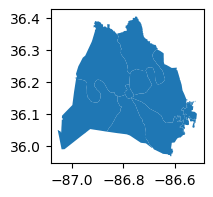

In [91]:
precinct_polygons.plot(figsize=(2,2))

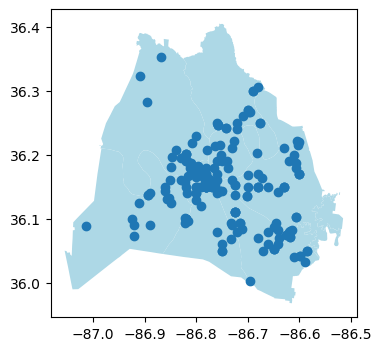

In [92]:
# YIPPEE
ax = precinct_polygons.plot(figsize=(4,4), color='lightblue')
incidents_trim[incidents_trim['inc_yr'] == 2025][0:200].plot(ax = ax);
plt.show();

#### Spatial Join (incidents_trim and precinct_polygons)

In [93]:
# I need to do a spatial join
# After my spatial join, I need to eliminate duplicates and join the polygon identifier column to my incidents trim dataframe.

In [94]:
incidents_trim.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.17,-86.6,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018,520,OTHER


In [95]:
# This is all I need from precinct polygons
precinct_polygons[['PRECINCT', 'geometry']].head(1)

,PRECINCT,geometry
0,HERMITAGE,"MULTIPOLYGON Z (((-86.57206 36.17936 0.00000, ..."


In [96]:
# Testing...
gpd.sjoin(incidents_trim[0:10], precinct_polygons[['PRECINCT', 'geometry']], how='left', predicate='intersects')

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,index_right,PRECINCT
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.170,-86.600,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018,520,OTHER,0,HERMITAGE
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,7,MADISON
2,3,20180005926_21,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35B,DRUG,7,MADISON
3,4,20180004613_11,20180004613,DISPATCHED,CLEARED BY ARREST,Closed,1519 1519,36.149,-86.720,22,"RESIDENCE, HOME",1.0,BURGLARY- AGGRAVATED,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,37210,2018-01-02 20:02:00,2018-01-02 22:37:00,POINT (-86.72000 36.14900),2018,220,THEFT,0,HERMITAGE
4,5,20180004654_22,20180004654,DISPATCHED,CLEARED BY ARREST,Closed,824 824,36.161,-86.798,22,"RESIDENCE, HOME",2.0,BURGLARY- AGGRAVATED,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37203,2018-01-02 20:19:00,2018-01-02 21:29:00,POINT (-86.79800 36.16100),2018,220,THEFT,1,NORTH
5,6,20180006084_11,20180006084,DISPATCHED,OPEN,Open,BRITISH WOODS DR,36.090,-86.650,90,APARTMENT,1.0,DAMAGE PROP - PRIVATE,CLUB,1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,None,2018-01-03 05:42:00,2018-01-03 05:47:00,POINT (-86.65000 36.09000),2018,290,PROPERTY,0,HERMITAGE
6,7,20180007079_11,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,1,No,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT,1,NORTH
7,8,20180007079_12,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT,1,NORTH
8,9,20180007631_11,20180007631,DISPATCHED,UNFOUNDED,Closed,3838 3838,36.092,-86.715,22,"RESIDENCE, HOME",1.0,"RECOVERY, STOLEN PROPERTY",NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37211,2018-01-03 16:00:00,2018-01-03 16:58:00,POINT (-86.71500 36.09200),2018,780,OTHER,6,SOUTH
9,10,20180004767_11,20180004767,DISPATCHED,UNFOUNDED,Closed,8226 8226,36.011,-86.698,22,"RESIDENCE, HOME",1.0,LOST PROPERTY,NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37013,2018-01-02 18:00:00,2018-01-02 21:34:00,POINT (-86.69800 36.01100),2018,810,OTHER,6,SOUTH


In [97]:
# Testing again...
gpd.sjoin(incidents_trim[0:10], precinct_polygons[['PRECINCT', 'geometry']], how='left', predicate='intersects').drop(columns='index_right')

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.170,-86.600,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018,520,OTHER,HERMITAGE
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON
2,3,20180005926_21,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35B,DRUG,MADISON
3,4,20180004613_11,20180004613,DISPATCHED,CLEARED BY ARREST,Closed,1519 1519,36.149,-86.720,22,"RESIDENCE, HOME",1.0,BURGLARY- AGGRAVATED,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,37210,2018-01-02 20:02:00,2018-01-02 22:37:00,POINT (-86.72000 36.14900),2018,220,THEFT,HERMITAGE
4,5,20180004654_22,20180004654,DISPATCHED,CLEARED BY ARREST,Closed,824 824,36.161,-86.798,22,"RESIDENCE, HOME",2.0,BURGLARY- AGGRAVATED,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37203,2018-01-02 20:19:00,2018-01-02 21:29:00,POINT (-86.79800 36.16100),2018,220,THEFT,NORTH
5,6,20180006084_11,20180006084,DISPATCHED,OPEN,Open,BRITISH WOODS DR,36.090,-86.650,90,APARTMENT,1.0,DAMAGE PROP - PRIVATE,CLUB,1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,None,2018-01-03 05:42:00,2018-01-03 05:47:00,POINT (-86.65000 36.09000),2018,290,PROPERTY,HERMITAGE
6,7,20180007079_11,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,1,No,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT,NORTH
7,8,20180007079_12,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT,NORTH
8,9,20180007631_11,20180007631,DISPATCHED,UNFOUNDED,Closed,3838 3838,36.092,-86.715,22,"RESIDENCE, HOME",1.0,"RECOVERY, STOLEN PROPERTY",NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37211,2018-01-03 16:00:00,2018-01-03 16:58:00,POINT (-86.71500 36.09200),2018,780,OTHER,SOUTH
9,10,20180004767_11,20180004767,DISPATCHED,UNFOUNDED,Closed,8226 8226,36.011,-86.698,22,"RESIDENCE, HOME",1.0,LOST PROPERTY,NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37013,2018-01-02 18:00:00,2018-01-02 21:34:00,POINT (-86.69800 36.01100),2018,810,OTHER,SOUTH


In [98]:
# Save entire spatial joined dataframe to sjoin
# NOTE: THIS WILL CAUSE SOME DUPLICATION DUE TO THE PREDICATE BEING 'INTERSECTS'. I WILL DEAL WITH THAT AFTERWARD.
sjoin = gpd.sjoin(incidents_trim, precinct_polygons[['PRECINCT', 'geometry']], how='left', predicate='intersects').drop(columns='index_right')

In [99]:
sjoin.head(3)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
0,1,20180005702_23,20180005702,DISPATCHED,OPEN,Open,BELL RD,36.170,-86.600,90,APARTMENT,2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,3,No,SOCIETY,None,None,None,None,None,2018-01-03 02:50:00,2018-01-03 04:15:00,POINT (-86.60000 36.17000),2018,520,OTHER,HERMITAGE
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON
2,3,20180005926_21,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35B,DRUG,MADISON


In [100]:
# let's compare the origina dataframe's size to the new one to check for duplication
incidents_trim.shape[0]

894114

In [101]:
# Moment of truth...
sjoin.shape[0]

894114

In [102]:
# NO DUPLICATION!!!! YIPEE!!
sjoin['objid'].nunique()

894114

In [103]:
# Couldn't be happier
incidents.shape[0]

894114

In [104]:
# Let's just double check cause I was really expecting duplication:
sjoin.loc[sjoin.duplicated() == True]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT


#### Filling Missing 'PRECINCT' values

In [105]:
# Checking for rows missing a precinct value
sjoin[sjoin['PRECINCT'].isna() == True]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
37,38,20180011542_11,20180011542,DISPATCHED,UNFOUNDED,Closed,& COLFAX DR,NaN,NaN,22,"RESIDENCE, HOME",1.0,POLICE INQUIRY,NONE,1,No,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,37214,2018-01-04 17:30:00,2018-01-04 18:26:00,None,2018,740,OTHER,NaN
85,86,20180017083_11,20180017083,DISPATCHED,OPEN,Open,MACLAURIN CT,NaN,NaN,22,"RESIDENCE, HOME",1.0,"THEFT OF PROPERTY- $1,000 OR > BUT < $10,000",Unarmed,1,No,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,None,2018-01-05 02:30:00,2018-01-06 05:41:00,None,2018,23H,THEFT,NaN
118,119,20180050801_11,20180050801,DISPATCHED,OPEN,Open,THUSS AVE,NaN,NaN,22,"RESIDENCE, HOME",1.0,INTENTIONAL AGGRAVATED ASSAULT,LETHAL/CUTTING INSTRUMENT,1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,None,2018-01-16 20:30:00,2018-01-17 01:30:00,None,2018,13A,OTHER,NaN
142,143,20180050781_11,20180050781,DISPATCHED,OPEN,Open,NORTHCREEK BLVD,36.33,-86.7,12,"GROCERY, SUPERMARKET",1.0,FRAUD - ILLEG USE OF CREDIT CARDS,NONE,1,No,BUSINESS,None,None,None,None,None,2018-01-10 18:00:00,2018-01-16 23:56:00,POINT (-86.70000 36.33000),2018,26B,OTHER,NaN
203,204,20180007466_11,20180007466,DISPATCHED,OPEN,Open,CHARLOTTE AVE,NaN,NaN,26,SPECIALTY STORE,1.0,LARC - FROM BLDG,NONE,1,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,NON RESIDENT,None,2018-01-02 23:00:00,2018-01-03 15:41:00,None,2018,23D,THEFT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893965,893966,20240513670_11,20240513670,DISPATCHED,UNFOUNDED,Closed,721 721,NaN,NaN,22,"RESIDENCE, HOME",1.0,POLICE INQUIRY,NONE,1,Yes,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,37076,2024-08-05 02:13:00,2024-08-05 03:12:00,None,2024,740,OTHER,NaN
893982,893983,20250192959_11,20250192959,DISPATCHED,OPEN,Open,None,NaN,NaN,6,CONSTRUCTION SITE,1.0,LARCENY - (FREE TEXT),Unarmed,1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,None,2025-03-27 05:44:00,2025-03-27 13:02:00,None,2025,23H,THEFT,NaN
894039,894040,20240468406_11,20240468406,DISPATCHED,UNFOUNDED,Closed,7218 7218,NaN,NaN,22,"RESIDENCE, HOME",1.0,POLICE INQUIRY,NONE,1,Yes,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,37221,2024-07-16 02:40:00,2024-07-16 03:53:00,None,2024,740,OTHER,NaN
894062,894063,20240481059_11,20240481059,None,UNFOUNDED,Closed,805 805,NaN,NaN,22,"RESIDENCE, HOME",1.0,POLICE INQUIRY,Unarmed,1,No,INDIVIDUAL (18 AND OVER),M,A,Non-Hispanic,RESIDENT,37209,2024-07-04 07:00:00,2024-07-21 11:51:00,None,2024,740,OTHER,NaN


In [106]:
# Aw :( lets see the damage
sjoin[sjoin['PRECINCT'].isna() == True].shape[0]

22331

In [107]:
# :'[ thats a lot. lets see how many are just straight up missing geometry
sjoin[(sjoin['PRECINCT'].isna() == True) & (sjoin['geometry'].isna() == True)].shape[0]

20869

In [108]:
# Oh we're chill
# I might just fill the precinct values with something like 'NO LOCATION'

# Lets check the remaining ~2000
sjoin[(sjoin['PRECINCT'].isna() == True) & (sjoin['geometry'].isna() == False)].shape[0]

1462

In [109]:
# Thats a little lower than I thought let me double check
20869 + 1462

22331

In [110]:
# Ok checks out. Let's take a look
sjoin[(sjoin['PRECINCT'].isna() == True) & (sjoin['geometry'].isna() == False)]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
142,143,20180050781_11,20180050781,DISPATCHED,OPEN,Open,NORTHCREEK BLVD,36.330,-86.700,12,"GROCERY, SUPERMARKET",1.0,FRAUD - ILLEG USE OF CREDIT CARDS,NONE,1,No,BUSINESS,None,None,None,None,None,2018-01-10 18:00:00,2018-01-16 23:56:00,POINT (-86.70000 36.33000),2018,26B,OTHER,NaN
1415,1416,20180018976_11,20180018976,DISPATCHED,UNFOUNDED,Closed,610 610,36.033,-86.781,26,SPECIALTY STORE,1.0,POLICE INQUIRY,NONE,1,No,BUSINESS,None,None,None,None,37027,2018-01-06 22:01:00,2018-01-06 23:29:00,POINT (-86.78100 36.03300),2018,740,OTHER,NaN
5113,5114,20180044361_11,20180044361,DISPATCHED,UNFOUNDED,Closed,4944 4944,36.036,-86.789,13,"HIGHWAY, ROAD, ALLEY",1.0,LOST PROPERTY,NONE,1,No,INDIVIDUAL (18 AND OVER),M,W,Hispanic,RESIDENT,37027,2018-01-14 21:00:00,2018-01-15 03:23:00,POINT (-86.78900 36.03600),2018,810,OTHER,NaN
5204,5205,20180007692_11,20180007692,WITNESS,OPEN,Open,SPRINGFIELD HWY,36.360,-86.720,13,"HIGHWAY, ROAD, ALLEY",1.0,AGGRAV ASSLT - NONFAMILY-GUN,HANDGUN,1,No,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,NON RESIDENT,None,2018-01-03 16:00:00,2018-01-03 16:44:00,POINT (-86.72000 36.36000),2018,13A,OTHER,NaN
5208,5209,20180007692_22,20180007692,WITNESS,OPEN,Open,SPRINGFIELD HWY,36.360,-86.720,13,"HIGHWAY, ROAD, ALLEY",2.0,"WEAPON OFFENSE, CRIMINAL ATTEMPT",HANDGUN,2,No,SOCIETY,None,None,None,None,None,2018-01-03 16:00:00,2018-01-03 16:44:00,POINT (-86.72000 36.36000),2018,520,OTHER,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893636,893637,20250032411_11,20250032411,SUSPECT,UNFOUNDED,Closed,REP JOHN LEWIS & DEMONBREUN,0.000,0.000,13,"HIGHWAY, ROAD, ALLEY",1.0,TRANSPORT,NONE,1,No,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,NON RESIDENT,37201,2025-01-16 23:17:00,2025-01-17 00:54:00,POINT (0.00000 0.00000),2025,740,OTHER,NaN
893692,893693,20240744085_11,20240744085,DISPATCHED,OPEN,Open,NORTHCREEK BLVD,36.330,-86.700,12,"GROCERY, SUPERMARKET",1.0,FRAUD - SWINDLE,NONE,1,No,BUSINESS,None,None,None,None,None,2024-11-02 20:00:00,2024-11-12 21:27:00,POINT (-86.70000 36.33000),2024,26A,OTHER,NaN
893695,893696,20240744085_22,20240744085,DISPATCHED,OPEN,Open,NORTHCREEK BLVD,36.330,-86.700,12,"GROCERY, SUPERMARKET",2.0,"FORGE/SIMULATE, CRIMINAL ATTEMPT",NONE,2,No,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,None,2024-11-02 20:00:00,2024-11-12 21:27:00,POINT (-86.70000 36.33000),2024,250,OTHER,NaN
893712,893713,20250226510_11,20250226510,DISPATCHED,OPEN,Open,BLUFF RD,36.000,-86.700,5,"COMMERCIAL, OFFICE BUILDING",1.0,EMBEZZLE - BUSINESS PROP,NONE,1,No,BUSINESS,None,None,None,None,None,2025-03-13 21:45:00,2025-04-10 19:34:00,POINT (-86.70000 36.00000),2025,270,OTHER,NaN


In [111]:
# Checking size cause I want to just throw it on a map and see what I get
sjoin[(sjoin['PRECINCT'].isna() == True) & (sjoin['geometry'].isna() == False) & (sjoin['inc_status_desc'] == 'CLEARED BY ARREST')].shape[0]

147

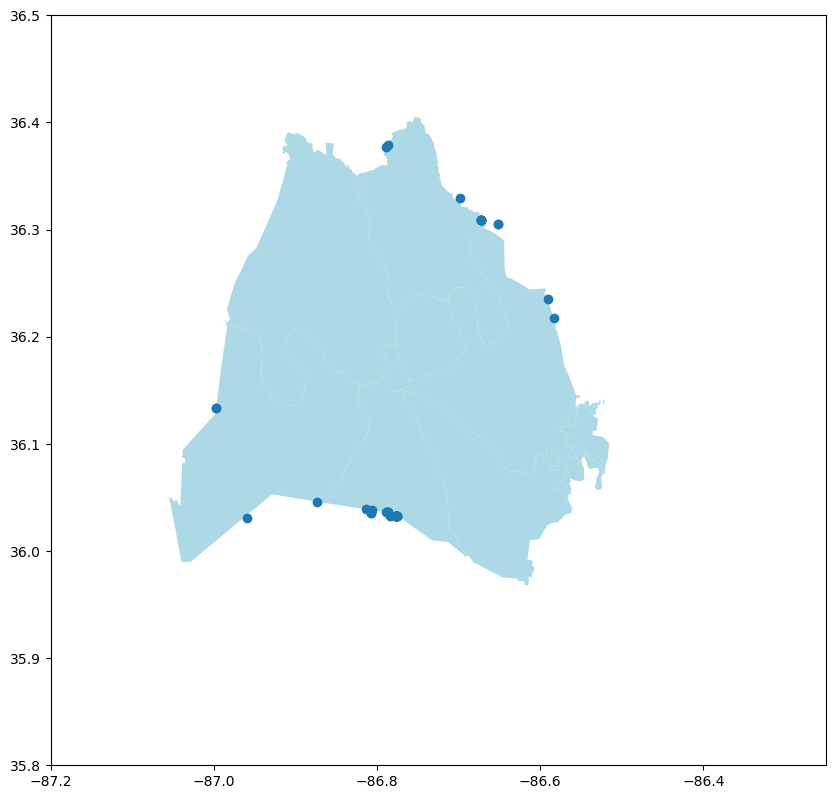

In [112]:
# I'm just gonna try to map it and see what happens
ax = precinct_polygons.plot(figsize=(10, 10), color='lightblue')
sjoin.loc[(sjoin['PRECINCT'].isna() == True) & (sjoin['geometry'].isna() == False) & (sjoin['inc_status_desc'] == 'CLEARED BY ARREST') & (sjoin['lat'] != 0)].plot(ax = ax);
ax.set_xlim(-87.2, -86.25) # This line and the next are to leave out some seriously extraordinary values
ax.set_ylim(35.8, 36.5)
plt.show();

In [113]:
# sjoin.loc[(sjoin['PRECINCT'].isna() == True) & (sjoin['geometry'].isna() == False) & (sjoin['inc_status_desc'] == 'CLEARED BY ARREST') & (sjoin['lat'] != 0)][['objid','geometry']].explore()

In [114]:
# Ripped object id's from map
# sjoin.loc[sjoin['objid'].isin(['815282','868659', '801163'])]

In [115]:
# Let's look at the locations more broadly
# sjoin.loc[sjoin['inc_loc'].isin(['I65 SOUTH & I24 EAST','I40 W & 2ND AVE S', 'REP JOHN LEWIS & DR MARTIN L KING JR'])]

##### Filling Missing Precinct Values

In [116]:
sjoin.loc[sjoin['inc_loc'] == 'I40  W & 2ND AVE S']

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
815281,815282,20240378360_11,20240378360,DISPATCHED,CLEARED BY ARREST,Closed,I40 W & 2ND AVE S,37.986,-101.756,13,"HIGHWAY, ROAD, ALLEY",1.0,DRIVING UNDER THE INFLUENCE - 2ND OFFENSE,NONE,1,No,SOCIETY,None,None,None,None,37210,2024-06-06 23:18:00,2024-06-07 02:41:00,POINT (-101.75600 37.98600),2024,90D,INTOXICATION,NaN


In [117]:
# Filling messed up rows
mask = (
    (sjoin['inc_loc'].isin(['I65 SOUTH & I24 EAST','I40 W & 2ND AVE S', 'I40  W & 2ND AVE S', 'REP JOHN LEWIS & DR MARTIN L KING JR'])) &
    (sjoin['PRECINCT'].isna() == True)
)
sjoin.loc[mask, 'PRECINCT'] = sjoin.loc[mask, 'PRECINCT'].fillna('NO LOCATION')

In [118]:
# LEGITNESS
sjoin.loc[sjoin['inc_loc'].isin(['I65 SOUTH & I24 EAST','I40 W & 2ND AVE S', 'I40  W & 2ND AVE S', 'REP JOHN LEWIS & DR MARTIN L KING JR'])]['PRECINCT'].unique()

array(['NO LOCATION'], dtype=object)

In [119]:
# Next I'll fill rows missing geometry
mask = (
    (sjoin['PRECINCT'].isna() == True) &
    (sjoin['geometry'].isna() == True)
)
sjoin.loc[mask, 'PRECINCT'] = sjoin.loc[mask, 'PRECINCT'].fillna('NO LOCATION')

In [120]:
sjoin.loc[(sjoin['geometry'].isna() == True)]['PRECINCT'].unique()

array(['NO LOCATION'], dtype=object)

In [121]:
# Filling lat, long = 0 rows
mask = (
    (sjoin['lat'] == 0) & 
    (sjoin['long'] == 0)
)
sjoin.loc[mask, 'PRECINCT'] = sjoin.loc[mask, 'PRECINCT'].fillna('NO LOCATION')

In [122]:
sjoin.loc[(sjoin['lat'] == 0) & (sjoin['long'] == 0)]['PRECINCT'].unique()

array(['NO LOCATION'], dtype=object)

In [123]:
# The rest of the rows are just slightly outside of davidson county so let's do that
mask = (
    (sjoin['PRECINCT'].isna() == True)
)
sjoin.loc[mask, 'PRECINCT'] = sjoin.loc[mask, 'PRECINCT'].fillna('OUTSIDE NASH')

In [124]:
# All values filled!
sjoin.loc[sjoin['PRECINCT'].isna() == True]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT


#### Filtering by arrests

In [125]:
# Checking to see if there are other records indicating arrest
sjoin['inc_status_desc'].value_counts()

inc_status_desc
OPEN                    424535
UNFOUNDED               271578
CLEARED BY ARREST       135490
REFUSED TO COOPERATE     55979
PROSECUTION DECLINED      4743
JUVENILE, NO CUSTODY      1029
DEATH OF OFFENDER          646
EXTRADITION DECLINED        12
Name: count, dtype: int64

In [126]:
# Nope, lets continue
sjoin.loc[sjoin['inc_status_desc'] == 'CLEARED BY ARREST'].shape[0]

135490

In [127]:
sjoin.columns

Index(['objid', 'primary_key', 'inc_num', 'report_desc', 'inc_status_desc',
       'investigation_status', 'inc_loc', 'lat', 'long', 'loc_code',
       'loc_desc', 'offense_num', 'offense_desc', 'weapon', 'v_num',
       'domestic_flag', 'v_desc', 'v_gender', 'v_race', 'v_ethnicity',
       'v_county_resident', 'zip', 'inc_time', 'report_time', 'geometry',
       'inc_yr', 'offense_nibrs', 'crime_cat', 'PRECINCT'],
      dtype='object')

In [128]:
# Lets see!
# sjoin.loc[(sjoin['inc_status_desc'] == 'CLEARED BY ARREST') & (~sjoin['PRECINCT'].isin(['NO LOCATION']))][['objid', 'geometry', 'PRECINCT']].explore()

# DEFINITELY runs better than some other maps I've tried to run lol.

### Mapping

#### Combining rows with same geometry

In [129]:
# I need to find a way to join row with same geometry.

# I plan to use my 'crime_cat' column to make descriptive popups.

In [130]:
sjoin.loc[(sjoin['inc_status_desc'] == 'CLEARED BY ARREST') & (~sjoin['PRECINCT'].isin(['NO LOCATION']))]

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON
2,3,20180005926_21,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35B,DRUG,MADISON
3,4,20180004613_11,20180004613,DISPATCHED,CLEARED BY ARREST,Closed,1519 1519,36.149,-86.720,22,"RESIDENCE, HOME",1.0,BURGLARY- AGGRAVATED,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,37210,2018-01-02 20:02:00,2018-01-02 22:37:00,POINT (-86.72000 36.14900),2018,220,THEFT,HERMITAGE
4,5,20180004654_22,20180004654,DISPATCHED,CLEARED BY ARREST,Closed,824 824,36.161,-86.798,22,"RESIDENCE, HOME",2.0,BURGLARY- AGGRAVATED,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37203,2018-01-02 20:19:00,2018-01-02 21:29:00,POINT (-86.79800 36.16100),2018,220,THEFT,NORTH
6,7,20180007079_11,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,1,No,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT,NORTH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894100,894101,20240479141_11,20240479141,SUSPECT,CLEARED BY ARREST,Closed,2300 2300,36.153,-86.688,20,"PARKING LOT, GARAGE",1.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37214,2024-07-20 12:14:00,2024-07-20 12:14:00,POINT (-86.68800 36.15300),2024,35B,DRUG,HERMITAGE
894102,894103,20240480321_11,20240480321,DISPATCHED,CLEARED BY ARREST,Closed,2901 2901,36.168,-86.822,11,"GOVERNMENT, PUBLIC BUILDING",1.0,"DRUGS, COCAINE, POSSESS",NONE,1,No,SOCIETY,None,None,None,None,37209,2024-07-21 02:25:00,2024-07-21 02:25:00,POINT (-86.82200 36.16800),2024,35A,DRUG,NORTH
894103,894104,20240480321_21,20240480321,DISPATCHED,CLEARED BY ARREST,Closed,2901 2901,36.168,-86.822,11,"GOVERNMENT, PUBLIC BUILDING",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37209,2024-07-21 02:25:00,2024-07-21 02:25:00,POINT (-86.82200 36.16800),2024,35B,DRUG,NORTH
894104,894105,20240480981_11,20240480981,SUSPECT,CLEARED BY ARREST,Closed,OLD HICKORY & HEAD,36.264,-86.734,13,"HIGHWAY, ROAD, ALLEY",1.0,POSSESSION OF A CONTROLLED SUBSTANCE,NONE,1,No,SOCIETY,None,None,None,None,37115,2024-07-21 09:41:00,2024-07-21 11:10:00,POINT (-86.73400 36.26400),2024,35A,DRUG,MADISON


In [131]:
# Saving my df to another variable so i don't mess everything up
map_df = sjoin.loc[(sjoin['inc_status_desc'] == 'CLEARED BY ARREST') & (~sjoin['PRECINCT'].isin(['NO LOCATION']))]

In [132]:
# This dataset is specifically for mapping, so I will drop 'NO LOCATION' rows.
map_df = map_df.drop(map_df.loc[map_df['PRECINCT'] == 'NO LOCATION'].index)

In [133]:
# Looking good
map_df['PRECINCT'].unique()

array(['MADISON', 'HERMITAGE', 'NORTH', 'CENTRAL', 'SOUTH',
       'MIDTOWN-HILLS', 'EAST', 'WEST', 'OUTSIDE NASH'], dtype=object)

In [134]:
# Check updated shape
map_df.shape[0]

134498

In [135]:
sjoin.shape[0]

894114

In [136]:
# I'm going to get really picky with my columns now
map_df.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON


In [137]:
map_df[['geometry', 'crime_cat']].groupby('geometry')['crime_cat'].apply(','.join).reset_index().shape[0]

15448

#### The IMPOSSIBLE MAP

In [138]:
geom_gb = gpd.GeoDataFrame(map_df[['geometry', 'crime_cat']].groupby('geometry')['crime_cat'].apply(','.join).reset_index())

In [139]:
geom_gb.head(20)

,geometry,crime_cat
0,POINT (-87.02300 36.02700),"OTHER,PROPERTY"
1,POINT (-87.01500 36.01600),OTHER
2,POINT (-87.03000 36.01600),OTHER
3,POINT (-87.02800 36.01000),OTHER
4,POINT (-87.02800 36.00600),OTHER
5,POINT (-87.03300 36.01700),OTHER
6,POINT (-87.02800 36.02000),"DRUG,DRUG,OTHER"
7,POINT (-87.02400 36.03000),THEFT
8,POINT (-87.00900 36.05400),OTHER
9,POINT (-87.04000 36.04700),"OTHER,OTHER"


In [140]:
# Lambda function to keep only unique crime_cats
geom_gb['crime_cat'] = geom_gb['crime_cat'].apply(lambda x: ', '.join(list(set(x.split(',')))))

In [141]:
geom_gb

,geometry,crime_cat
0,POINT (-87.02300 36.02700),"OTHER, PROPERTY"
1,POINT (-87.01500 36.01600),OTHER
2,POINT (-87.03000 36.01600),OTHER
3,POINT (-87.02800 36.01000),OTHER
4,POINT (-87.02800 36.00600),OTHER
...,...,...
15443,POINT (-86.58400 36.02800),OTHER
15444,POINT (-86.58300 36.02800),OTHER
15445,POINT (-86.58300 36.02700),"THEFT, OTHER"
15446,POINT (-86.58400 36.02700),OTHER


In [142]:
geom_gb.shape[0]

15448

In [ ]:
# THE IMPOSSIBLE MAP
# geom_gb.explore()

##### Heatmap of crime

In [148]:
map_df.head()

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON
2,3,20180005926_21,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",2.0,DRUG PARAPHERNALIA- UNLAWFUL USE,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35B,DRUG,MADISON
3,4,20180004613_11,20180004613,DISPATCHED,CLEARED BY ARREST,Closed,1519 1519,36.149,-86.720,22,"RESIDENCE, HOME",1.0,BURGLARY- AGGRAVATED,PERSONAL (HANDS),1,No,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,37210,2018-01-02 20:02:00,2018-01-02 22:37:00,POINT (-86.72000 36.14900),2018,220,THEFT,HERMITAGE
4,5,20180004654_22,20180004654,DISPATCHED,CLEARED BY ARREST,Closed,824 824,36.161,-86.798,22,"RESIDENCE, HOME",2.0,BURGLARY- AGGRAVATED,NONE,2,No,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,37203,2018-01-02 20:19:00,2018-01-02 21:29:00,POINT (-86.79800 36.16100),2018,220,THEFT,NORTH
6,7,20180007079_11,20180007079,DISPATCHED,CLEARED BY ARREST,Closed,1911 1911,36.164,-86.807,13,"HIGHWAY, ROAD, ALLEY",1.0,BURGLARY- MOTOR VEHICLE,NONE,1,No,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,37208,2018-01-03 03:00:00,2018-01-03 15:21:00,POINT (-86.80700 36.16400),2018,23F,THEFT,NORTH


In [149]:
# Extracting coordinates for heatmap
lat_longs = list(map(list, zip(map_df["lat"], map_df["long"])))
lat_longs[:5]

[[36.269, -86.756],
 [36.269, -86.756],
 [36.149, -86.72],
 [36.161, -86.798],
 [36.164, -86.807]]

In [150]:
m = folium.Map(location=[36.174465, -86.767960], zoom_start=10)
HeatMap(lat_longs).add_to(m)

In [151]:
m

### Charts

In [252]:
# Coloring
colors = ["#032c3c", "#970808", '#f29544']
sns.set_palette(sns.color_palette(colors))

# Style
sns.set(rc={'axes.facecolor':'#eaeaea', 
            "axes.edgecolor" : '032c3c',
            "axes.labelcolor" : '032c3c',
            'figure.facecolor':'#eaeaea',
            'grid.color' : "#032c3c"})

In [253]:
# _style_keys = [
#     "axes.facecolor", "axes.edgecolor",
#     "axes.grid", "axes.axisbelow", "axes.labelcolor",

#     "figure.facecolor", "grid.color", 
#     "grid.linestyle", "text.color",

#     "xtick.color", "ytick.color",
#     "xtick.direction", "ytick.direction", 
#     "lines.solid_capstyle",

#     "patch.edgecolor", "patch.force_edgecolor",

#     "image.cmap", "font.family", "font.sans-serif",

#     "xtick.bottom", "xtick.top",
#     "ytick.left", "ytick.right",

#     "axes.spines.left", "axes.spines.bottom",
#     "axes.spines.right", "axes.spines.top",]

# _context_keys = [
#     "font.size", "axes.labelsize",
#     "axes.titlesize", "xtick.labelsize",
#     "ytick.labelsize", "legend.fontsize",

#     "axes.linewidth", "grid.linewidth",
#     "lines.linewidth", "lines.markersize",
#     "patch.linewidth",

#     "xtick.major.width", "ytick.major.width",
#     "xtick.minor.width", "ytick.minor.width",

#     "xtick.major.size", "ytick.major.size",
#     "xtick.minor.size", "ytick.minor.size",]

#### Arrests by Police Precinct

In [254]:
map_df.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON


In [255]:
# Making sure i'm only using arrests
map_df['inc_status_desc'].unique()

array(['CLEARED BY ARREST'], dtype=object)

In [256]:
# Group By
arrests_byprecinct = (map_df[~map_df['PRECINCT'].isin(['OUTSIDE NASH'])]
                      .groupby('PRECINCT')['objid']
                      .count()
                      .reset_index()
                      .sort_values('objid', ascending=False)
                     )
arrests_byprecinct

,PRECINCT,objid
6,SOUTH,25295
2,HERMITAGE,21611
5,NORTH,19585
1,EAST,16499
3,MADISON,15432
0,CENTRAL,13152
4,MIDTOWN-HILLS,13102
7,WEST,9775


In [268]:
sns.set_palette(sns.color_palette(colors))

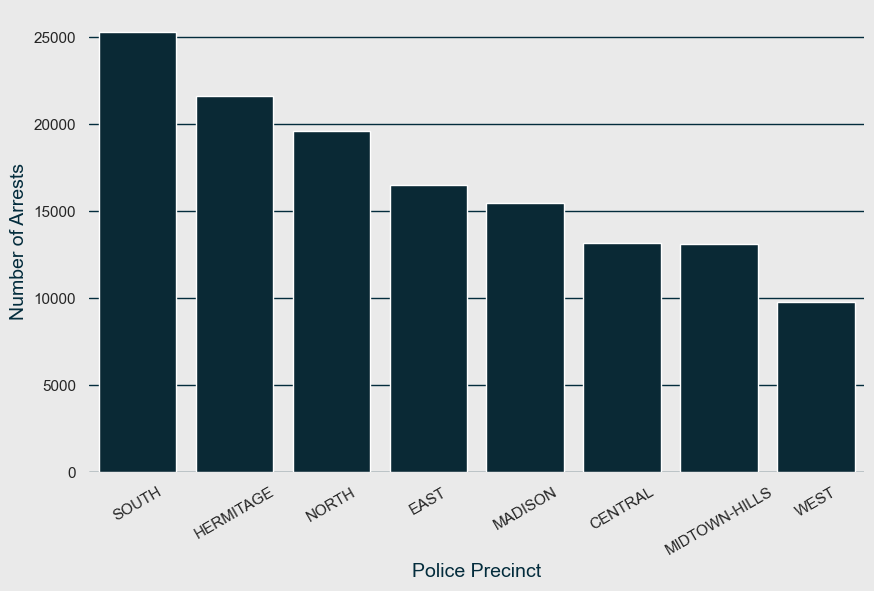

In [269]:
# Bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y="objid", 
    x="PRECINCT", 
    data=arrests_byprecinct)
ax.set_xlabel("Police Precinct", fontsize = 14)
ax.set_ylabel("Number of Arrests", fontsize = 14)
plt.xticks(rotation=30)
sns.despine(ax=ax, left=True, bottom=True)

#### Arrests by Crime Type and Precinct

In [326]:
# Renaming 'Midtown-Hills' to 'Midtown'
mask = (map_df['PRECINCT'].isin(['MIDTOWN-HILLS']))
map_df.loc[mask, 'PRECINCT'] = map_df.loc[mask, 'PRECINCT'] = 'MIDTOWN'

In [327]:
map_df['crime_cat'].unique()

array(['DRUG', 'THEFT', 'OTHER', 'PROPERTY', 'SEXUAL', 'MURDER',
       'INTOXICATION', 'SUICIDE'], dtype=object)

In [328]:
crime_categories = (map_df[(~map_df['crime_cat'].isin(['OTHER', 'SUICIDE', 'SEXUAL', 'MURDER', 'INTOXICATION'])) & (~map_df['PRECINCT'].isin(['OUTSIDE NASH']))]
                      .groupby(['PRECINCT','crime_cat'])['objid']
                      .count()
                      .reset_index()
                      .sort_values('objid', ascending=False)
                     )
crime_categories

,PRECINCT,crime_cat,objid
18,SOUTH,DRUG,5331
6,HERMITAGE,DRUG,4898
15,NORTH,DRUG,4577
20,SOUTH,THEFT,4124
0,CENTRAL,DRUG,3960
11,MADISON,THEFT,3712
8,HERMITAGE,THEFT,3687
3,EAST,DRUG,3530
14,MIDTOWN,THEFT,3298
23,WEST,THEFT,3029


In [329]:
sns.set_palette(sns.color_palette(colors))

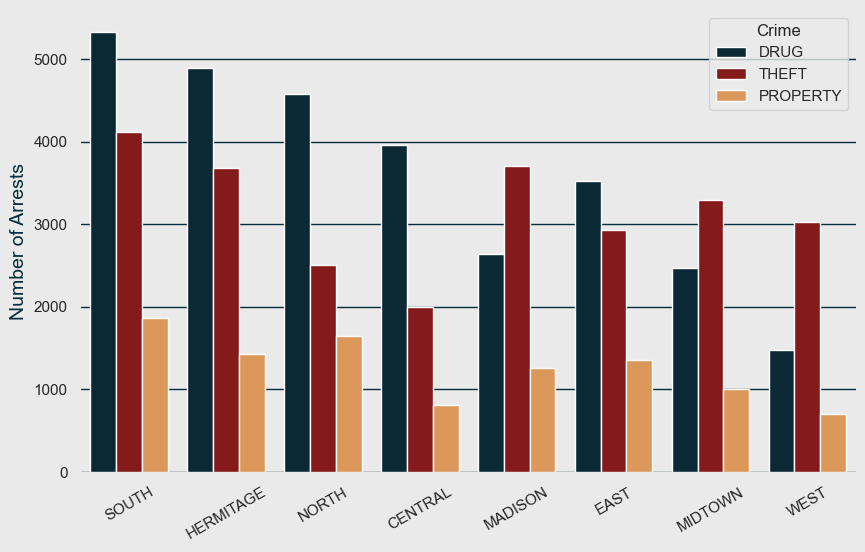

In [331]:
# Bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y="objid", 
    x="PRECINCT", 
    hue='crime_cat',
    data=crime_categories)
ax.set_xlabel("", fontsize = 14)
ax.set_ylabel("Number of Arrests", fontsize = 14)
plt.xticks(rotation=30)
plt.legend(title='Crime', loc='upper right')
sns.despine(ax=ax, left=True, bottom=True)

#### Heatmap?

In [270]:
map_df.head(1)

,objid,primary_key,inc_num,report_desc,inc_status_desc,investigation_status,inc_loc,lat,long,loc_code,loc_desc,offense_num,offense_desc,weapon,v_num,domestic_flag,v_desc,v_gender,v_race,v_ethnicity,v_county_resident,zip,inc_time,report_time,geometry,inc_yr,offense_nibrs,crime_cat,PRECINCT
1,2,20180005926_11,20180005926,SUSPECT,CLEARED BY ARREST,Closed,DICKERSON PIKE & OLD HICKORY BLVD W,36.269,-86.756,13,"HIGHWAY, ROAD, ALLEY",1.0,MARIJUANA - POSSESS,NONE,1,No,SOCIETY,None,None,None,None,37115,2018-01-03 04:20:00,2018-01-03 04:42:00,POINT (-86.75600 36.26900),2018,35A,DRUG,MADISON


In [276]:
# I already have a good dataset for this!
arrests_byprecinct

,PRECINCT,objid
6,SOUTH,25295
2,HERMITAGE,21611
5,NORTH,19585
1,EAST,16499
3,MADISON,15432
0,CENTRAL,13152
4,MIDTOWN-HILLS,13102
7,WEST,9775


In [277]:
# I'll join back to precinct_polygons to get the geometry
precinct_polygons

,GLOBALID,STArea,PRECINCT,STLength,geometry
0,{02BF999B-4A77-4BE8-B649-F9C1B6791098},2.495822e+09,HERMITAGE,521816.110974,"MULTIPOLYGON Z (((-86.57206 36.17936 0.00000, ..."
1,{6BBB73D8-5BD5-46AE-9F1D-7E45CF656617},3.287797e+09,NORTH,334750.611226,"MULTIPOLYGON Z (((-86.91111 36.35730 0.00000, ..."
2,{AEC0E873-A9E6-4C51-995B-589E9368D587},3.036712e+09,WEST,314367.315791,"MULTIPOLYGON Z (((-86.99797 36.12802 0.00000, ..."
3,{FC11B41E-DA35-4041-82E3-E3DE1D18052E},9.854197e+07,CENTRAL,46234.671731,"MULTIPOLYGON Z (((-86.77525 36.14895 0.00000, ..."
4,{99AB52A5-D98D-47AC-8C6E-989CA7B7FF4D},1.316292e+09,MIDTOWN-HILLS,185915.976901,"MULTIPOLYGON Z (((-86.84742 36.04288 0.00000, ..."
5,{48FB99C8-2923-473B-A3D4-E9C3CE7995DC},5.990601e-01,WEST,490.159242,"MULTIPOLYGON Z (((-86.91811 36.05157 0.00000, ..."
6,{D3570BDE-5106-4188-BD15-3001234FD1B0},1.930623e+09,SOUTH,424598.235332,"MULTIPOLYGON Z (((-86.63683 36.07255 0.00000, ..."
7,{87F0086F-27E2-477A-92AE-AE76341CDECB},1.913515e+09,MADISON,252748.633470,"MULTIPOLYGON Z (((-86.74955 36.24047 0.00000, ..."
8,{6E39B1E9-64EE-4FDC-97C5-5DC4398734A4},5.622602e+08,EAST,90261.133897,"MULTIPOLYGON Z (((-86.74978 36.24058 0.00000, ..."


In [280]:
heatmap = pd.merge(left=precinct_polygons[['PRECINCT', 'geometry']], right=arrests_byprecinct, how='left', on='PRECINCT')

In [320]:
heatmap

,PRECINCT,geometry,objid,centroid
0,HERMITAGE,"MULTIPOLYGON Z (((-86.57206 36.17936 0.00000, ...",21611,POINT (-86.63658 36.16462)
1,NORTH,"MULTIPOLYGON Z (((-86.91111 36.35730 0.00000, ...",19585,POINT (-86.87461 36.25565)
2,WEST,"MULTIPOLYGON Z (((-86.99797 36.12802 0.00000, ...",9775,POINT (-86.93664 36.10266)
3,CENTRAL,"MULTIPOLYGON Z (((-86.77525 36.14895 0.00000, ...",13152,POINT (-86.77888 36.16794)
4,MIDTOWN,"MULTIPOLYGON Z (((-86.84742 36.04288 0.00000, ...",13102,POINT (-86.77745 36.07749)
5,WEST,"MULTIPOLYGON Z (((-86.91811 36.05157 0.00000, ...",9775,POINT (-86.91861 36.05163)
6,SOUTH,"MULTIPOLYGON Z (((-86.63683 36.07255 0.00000, ...",25295,POINT (-86.64803 36.05881)
7,MADISON,"MULTIPOLYGON Z (((-86.74955 36.24047 0.00000, ...",15432,POINT (-86.74077 36.29955)
8,EAST,"MULTIPOLYGON Z (((-86.74978 36.24058 0.00000, ...",16499,POINT (-86.73801 36.19985)


In [296]:
heatmap['PRECINCT'].unique()

array(['HERMITAGE', 'NORTH', 'WEST', 'CENTRAL', 'MIDTOWN-HILLS', 'SOUTH',
       'MADISON', 'EAST'], dtype=object)

In [321]:
# Leaving 'Central' out of the labeling
precincts_to_annotate = ['HERMITAGE', 'NORTH', 'WEST', 'MIDTOWN', 'SOUTH', 'MADISON', 'EAST']

# Getting Centroids
heatmap['centroid'] = heatmap.geometry.centroid
heatmap['centroid'] = heatmap['centroid'].to_crs(heatmap.crs)

C:\Users\nunuk\AppData\Local\Temp\ipykernel_2344\3764632139.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  heatmap['centroid'] = heatmap.geometry.centroid


In [322]:
# Fonts
font = load_font(
   'https://github.com/dharmatype/Bebas-Neue/blob/master/fonts/BebasNeue(2018)ByDhamraType/ttf/BebasNeue-Regular.ttf?raw=true'
)
other_font = load_font(
   'https://github.com/bBoxType/FiraSans/blob/master/Fira_Sans_4_3/Fonts/Fira_Sans_TTF_4301/Normal/Roman/FiraSans-Light.ttf?raw=true'
)
other_bold_font = load_font(
   'https://github.com/bBoxType/FiraSans/blob/master/Fira_Sans_4_3/Fonts/Fira_Sans_TTF_4301/Normal/Roman/FiraSans-Medium.ttf?raw=true'
)

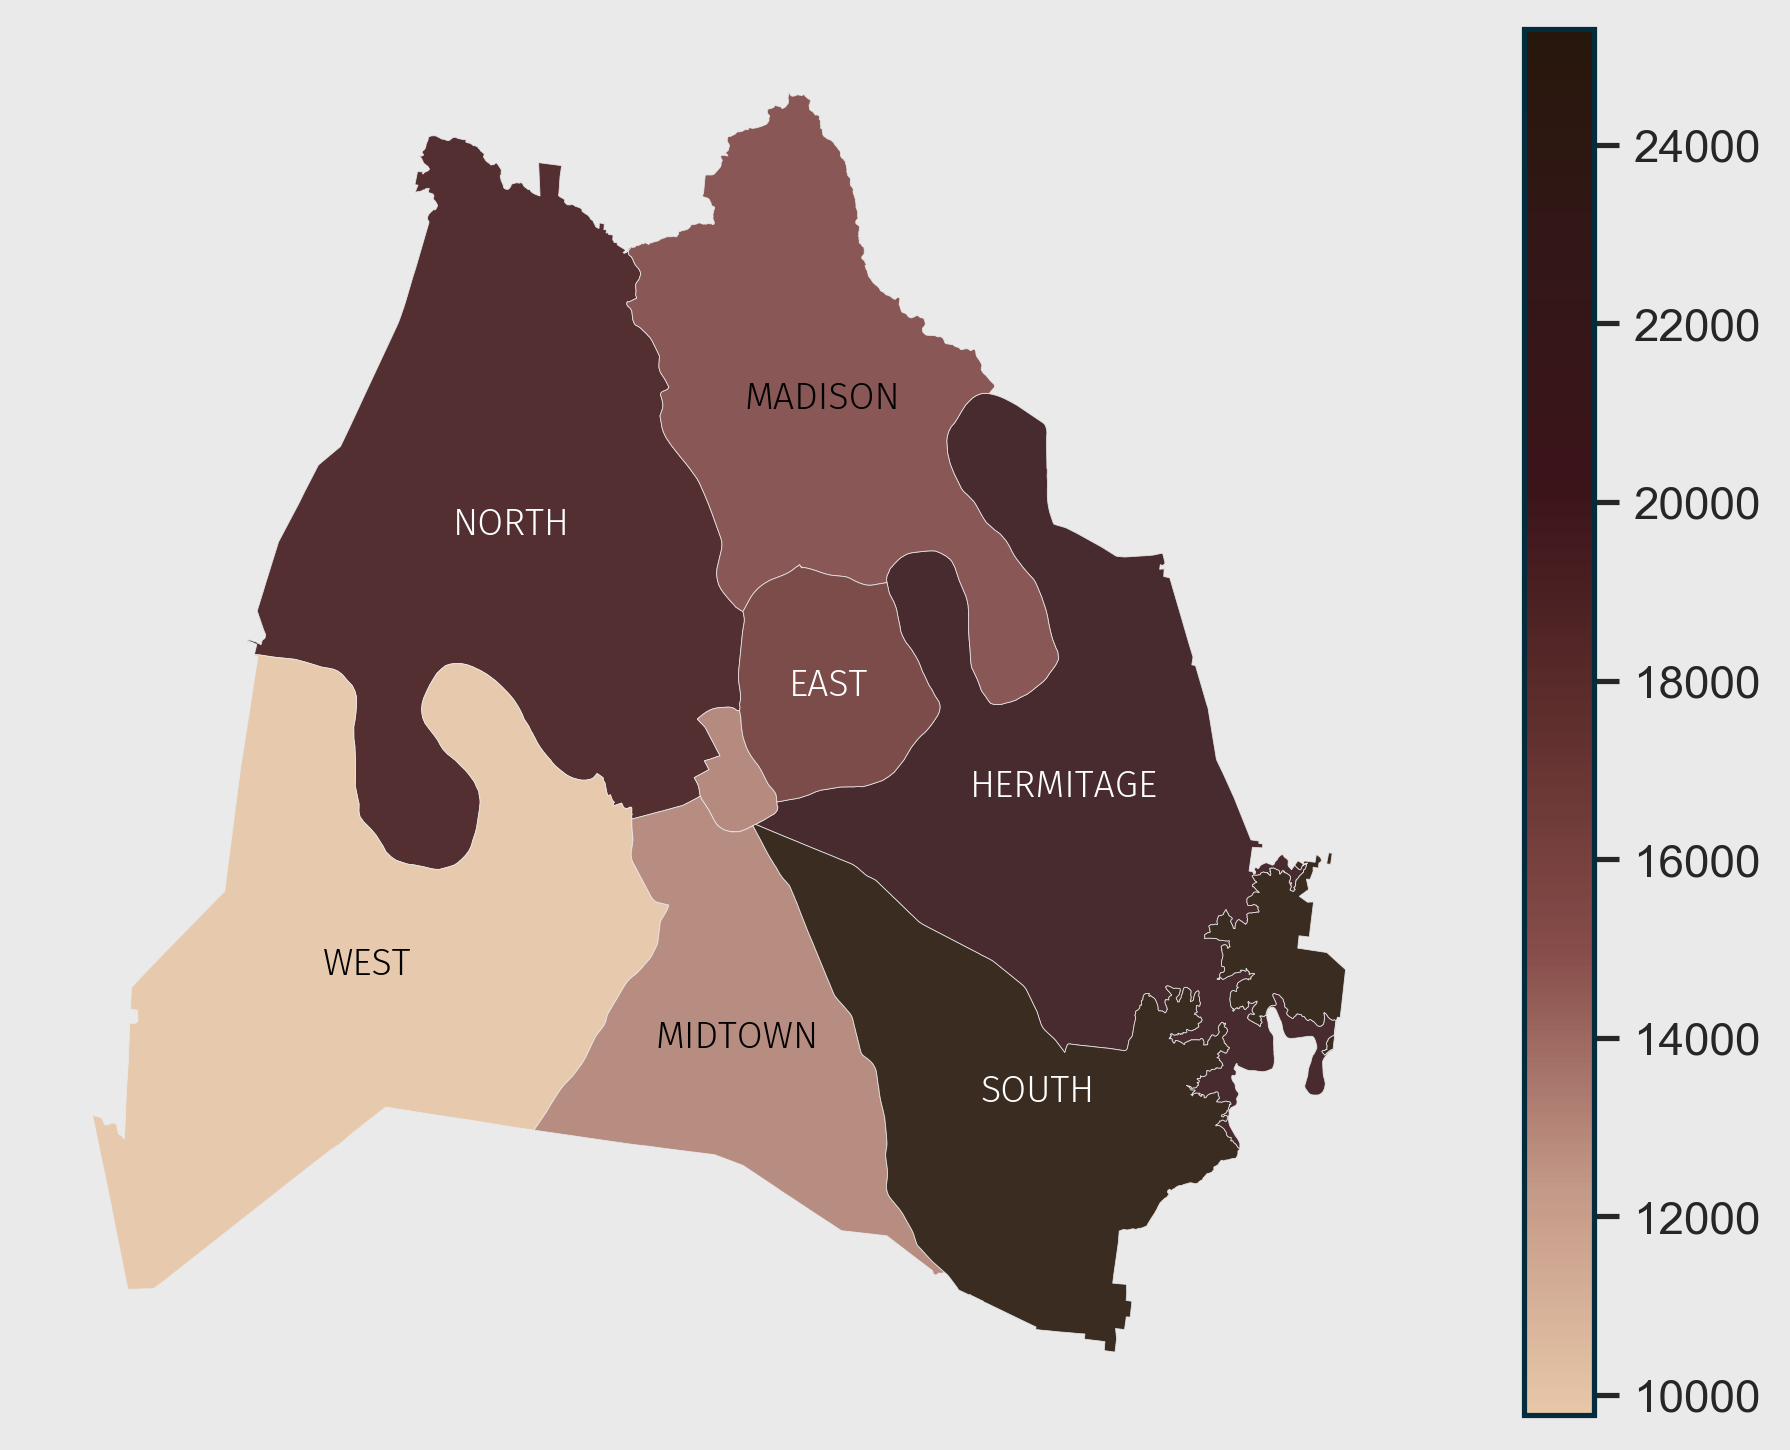

In [323]:
# Plot heatmap
sns.set_palette(sns.color_palette(colors))
palette_name = "Aurora"
cmap = load_cmap(palette_name, cmap_type="continuous")

fig, ax = plt.subplots(figsize=(10,6), dpi=300)
ax.axis("off")
heatmap.plot(ax=ax, column="objid", cmap=cmap, edgecolor="#eaeaea", linewidth=0.2, alpha=0.9, legend=True)

# Labeling
for precinct in precincts_to_annotate:
    centroid = heatmap.loc[heatmap['PRECINCT'] == precinct, 'centroid'].values[0]
    x, y = centroid.coords[0]
    if heatmap.loc[heatmap['PRECINCT'] == precinct]['objid'].values[0] > 16000:
        textcolor='white'
    else:
        textcolor='black'
    ax_text(
      x=x, y=y, s=f"<{precinct.upper()}>", fontsize=9, font=other_font, color=textcolor,
      ha='center', va='center', ax=ax)
plt.show()

In [294]:
mini_ax = ax.inset_axes(bounds=(0.58, 0.22, 0.15, 0.25), transform=fig.transFigure)
mini_ax.axis("off")
sns.barplot(
    data=heatmap,
    x="PRECINCT",
    y="objid",
    palette=palette_name,
    ax=mini_ax,
    hue="PRECINCT",
    legend=False
)
mini_ax.axvline(x=0, color="black")
mini_ax.invert_yaxis()

for index, row in heatmap.iterrows():
    x_pos = row["share"] - 6 if row["share"] > 4 else row["share"] + 1
    y_pos = index
    color = "white" if index in [5, 6] else "black"
    mini_ax.text(x_pos, y_pos, row["label"], color=color, size=7, va="center")
    mini_ax.text(-10, y_pos, row["group_hdi"], color="black", size=6, va="center")
plt.show()